# 🎯 Computer Vision Project: Object Detection

**Classi Target:** Horse, Lizard, Mouse, Hamster, Mule

## 📋 Obiettivi del Progetto

1. ✅ **Object Detection** con YOLO pre-addestrato
2. ✅ Download dataset da **OpenImages** tramite **FiftyOne**
3. ✅ Ottimizzazione modello (data augmentation, hyperparameter tuning)
4. ✅ Test set: ≥100 immagini, ≥10 immagini/classe
5. ✅ Metriche: mAP@0.5, mAP@0.5:0.95, Precision, Recall
6. ✅ Visualizzazioni: predictions, confusion matrix, PR curves
7. ⭐ **BONUS**: Confronto con modello HuggingFace

---

## 🛠️ Ambiente: Google Colab (GPU/TPU enabled)

# 1️⃣ Setup & Installazioni

Installiamo tutte le librerie necessarie per il progetto.

### 📦 Librerie principali:
- **ultralytics**: YOLOv8 per object detection
- **fiftyone**: gestione dataset OpenImages
- **torch/torchvision**: backend deep learning
- **opencv-python**: elaborazione immagini
- **matplotlib/seaborn**: visualizzazioni
- **scikit-learn**: metriche aggiuntive

In [1]:
# Installazione librerie principali
!pip install -q ultralytics fiftyone opencv-python-headless
!pip install -q matplotlib seaborn plotly scikit-learn pandas
!pip install -q transformers datasets # Per il bonus HuggingFace

print("✅ Installazione completata!")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 135.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.0/309.0 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.8 MB/s eta 0:00

In [2]:
# Import librerie
import os
import json
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.auto import tqdm

# Deep Learning
import torch
import torchvision
from ultralytics import YOLO
import ultralytics

# FiftyOne per dataset
import fiftyone as fo
import fiftyone.zoo as foz

# Sklearn per metriche aggiuntive
from sklearn.metrics import confusion_matrix, classification_report

# Configurazione visualizzazioni
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Verifica GPU
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"\n📊 Ultralytics version: {ultralytics.__version__}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


🔥 PyTorch version: 2.9.0+cu126
🎮 CUDA available: True
   GPU: NVIDIA A100-SXM4-40GB
   GPU Memory: 42.47 GB

📊 Ultralytics version: 8.3.233


In [3]:
# Configurazione globale del progetto
CONFIG = {
    'classes': ['Horse', 'Lizard', 'Mouse', 'Hamster', 'Mule'],
    'num_classes': 5,
    'dataset_name': 'animals-yolo',
    'base_path': Path('/content/datasets'),
    'min_images_per_class': 10,
    'min_test_images': 100,
    'train_ratio': 0.70,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    'seed': 42
}

# Creazione struttura directory
CONFIG['base_path'].mkdir(parents=True, exist_ok=True)
print("✅ Configurazione inizializzata")
print(f"📁 Base path: {CONFIG['base_path']}")
print(f"🎯 Classi: {', '.join(CONFIG['classes'])}")

✅ Configurazione inizializzata
📁 Base path: /content/datasets
🎯 Classi: Horse, Lizard, Mouse, Hamster, Mule


# 2️⃣ Download Dataset con FiftyOne (OpenImages)

## 🔍 Perché OpenImages?
- **Grande varietà**: milioni di immagini annotate
- **Annotazioni multiple**: bounding boxes + segmentation masks
- **Qualità**: annotazioni verificate da umani
- **Accessibilità**: integrazione diretta con FiftyOne

## 📦 FiftyOne
FiftyOne è una libreria che semplifica:
- Download di dataset pubblici (OpenImages, COCO, etc.)
- Visualizzazione e analisi esplorativa
- Filtraggio e split dei dati
- Export in formati standard (YOLO, COCO, etc.)

In [4]:
# Download dataset da OpenImages v7
# Scaricheremo solo le immagini che contengono almeno una delle nostre classi
# OpenImages supporta sia detection che segmentation masks

print("🚀 Inizio download da OpenImages...")
print(f"📦 Classi richieste: {CONFIG['classes']}\n")

# Download del dataset con le classi specificate
# max_samples=None per scaricare tutte le immagini disponibili (full version)
# Questo può richiedere diversi minuti
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="train",  # Useremo il train split di OpenImages, poi faremo il nostro split
    label_types=["detections", "segmentations"],  # Scarica sia bbox che maschere
    classes=CONFIG['classes'],
    max_samples=None,  # Full version: scarica tutto
    dataset_name="openimages_animals"
)

print(f"\n✅ Dataset scaricato!")
print(f"📊 Numero totale immagini: {len(dataset)}")
print(f"📁 Dataset name: {dataset.name}")

🚀 Inizio download da OpenImages...
📦 Classi richieste: ['Horse', 'Lizard', 'Mouse', 'Hamster', 'Mule']



INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v7/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/root/fiftyone/open-images-v7/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [28.5s elapsed, 0s remaining, 196.3Mb/s]      


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [28.5s elapsed, 0s remaining, 196.3Mb/s]      


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v7/train/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v7/train/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpthvkp16f/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv' to '/root/fiftyone/open-images-v7/train/labels/detections.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v7/train/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-2.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/2.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-d.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/D.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-7.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/7.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-3.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/3.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-e.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/E.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-1.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/1.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-f.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/F.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-b.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/B.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-0.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-6.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/6.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-9.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/9.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-5.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/5.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-8.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/8.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-4.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/4.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-a.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/A.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-c.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/C.zip'


INFO:fiftyone.utils.openimages:Downloading 10090 images


 100% |███████████████| 10090/10090 [8.3m elapsed, 0s remaining, 20.2 files/s]      


INFO:eta.core.utils: 100% |███████████████| 10090/10090 [8.3m elapsed, 0s remaining, 20.2 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'train'


 100% |█████████████| 10090/10090 [8.0m elapsed, 0s remaining, 18.8 samples/s]       


INFO:eta.core.utils: 100% |█████████████| 10090/10090 [8.0m elapsed, 0s remaining, 18.8 samples/s]       


Dataset 'openimages_animals' created


INFO:fiftyone.zoo.datasets:Dataset 'openimages_animals' created



✅ Dataset scaricato!
📊 Numero totale immagini: 10090
📁 Dataset name: openimages_animals


In [5]:
# Analisi esplorativa del dataset
print("📊 ANALISI ESPLORATIVA DEL DATASET\n")
print("="*60)

# Conteggio immagini per classe
class_counts = {}
for sample in dataset:
    if sample.detections is not None:
        for detection in sample.detections.detections:
            label = detection.label
            class_counts[label] = class_counts.get(label, 0) + 1

print("\n🎯 Numero di annotazioni (bounding boxes) per classe:")
for cls in CONFIG['classes']:
    count = class_counts.get(cls, 0)
    print(f"   {cls:12s}: {count:4d} annotazioni")

print(f"\n📸 Totale immagini nel dataset: {len(dataset)}")

# Verifica disponibilità segmentation masks
samples_with_segm = sum(1 for s in dataset if s.segmentations is not None and len(s.segmentations.detections) > 0)
print(f"🎨 Immagini con segmentation masks: {samples_with_segm}")

print("="*60)

📊 ANALISI ESPLORATIVA DEL DATASET


🎯 Numero di annotazioni (bounding boxes) per classe:
   Horse       : 13368 annotazioni
   Lizard      : 2120 annotazioni
   Mouse       :  857 annotazioni
   Hamster     :  546 annotazioni
   Mule        : 1117 annotazioni

📸 Totale immagini nel dataset: 10090
🎨 Immagini con segmentation masks: 7906


In [6]:
# Visualizzazione di alcune immagini di esempio
# Questo ci aiuta a capire la qualità e varietà del dataset

import matplotlib.patches as mpatches

def visualize_sample(sample, title=""):
    """Visualizza un sample con bounding boxes"""
    img = cv2.imread(sample.filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Disegna bounding boxes
    if sample.detections:
        colors = plt.cm.tab10(np.linspace(0, 1, len(CONFIG['classes'])))
        class_colors = {cls: colors[i] for i, cls in enumerate(CONFIG['classes'])}

        for det in sample.detections.detections:
            # Coordinate normalizzate -> pixel
            x, y, w, h = det.bounding_box
            x, y, w, h = x * img.shape[1], y * img.shape[0], w * img.shape[1], h * img.shape[0]

            color = class_colors.get(det.label, (1, 1, 1))
            rect = mpatches.Rectangle(
                (x, y), w, h,
                linewidth=3,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)

            # Label
            ax.text(
                x, y - 10,
                det.label,
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.7),
                fontsize=10,
                color='white',
                fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# Mostra 3 esempi casuali per ogni classe
print("🖼️  VISUALIZZAZIONE ESEMPI DEL DATASET\n")

for target_class in CONFIG['classes']:
    # Trova un sample che contiene la classe target
    for sample in dataset:
        if sample.detections:
            labels = [d.label for d in sample.detections.detections]
            if target_class in labels:
                visualize_sample(sample, f"Esempio: {target_class}")
                break

Output hidden; open in https://colab.research.google.com to view.

# 3️⃣ Preparazione Dataset YOLO-ready

## 🎯 Obiettivi di questa sezione:
1. **Filtrare** le immagini di qualità
2. **Bilanciare** il dataset tra le classi
3. **Splittare** in Train/Val/Test (70%/15%/15%)
4. **Verificare** vincoli:
   - Test set ≥ 100 immagini
   - Test set ≥ 10 immagini per classe
5. **Esportare** in formato YOLO con file `data.yaml`

## 📁 Formato YOLO
```
datasets/animals-yolo/
├── images/
│   ├── train/
│   ├── val/
│   └── test/
├── labels/
│   ├── train/
│   ├── val/
│   └── test/
└── data.yaml
```

Ogni file `.txt` in `labels/` contiene una riga per ogni oggetto:
```
<class_id> <x_center> <y_center> <width> <height>
```
Tutte le coordinate sono normalizzate [0, 1].

In [7]:
# Split del dataset in Train/Val/Test
import random

print("✂️  SPLITTING DEL DATASET\n")
print("="*60)

# Imposta seed per riproducibilità
random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Calcola le dimensioni degli split
total_samples = len(dataset)
train_size = int(total_samples * CONFIG['train_ratio'])
val_size = int(total_samples * CONFIG['val_ratio'])
test_size = total_samples - train_size - val_size

print(f"📊 Totale immagini: {total_samples}")
print(f"   Train: {train_size} ({CONFIG['train_ratio']*100:.0f}%)")
print(f"   Val:   {val_size} ({CONFIG['val_ratio']*100:.0f}%)")
print(f"   Test:  {test_size} ({CONFIG['test_ratio']*100:.0f}%)")

# Crea gli split usando FiftyOne
# Questo assicura che le immagini non si sovrappongano tra i set
import fiftyone.utils.random as four

four.random_split(
    dataset,
    {
        "train": CONFIG['train_ratio'],
        "val": CONFIG['val_ratio'],
        "test": CONFIG['test_ratio']
    },
    seed=CONFIG['seed']
)

# Verifica gli split
train_view = dataset.match_tags("train")
val_view = dataset.match_tags("val")
test_view = dataset.match_tags("test")

print(f"\n✅ Split completato!")
print(f"   Train samples: {len(train_view)}")
print(f"   Val samples:   {len(val_view)}")
print(f"   Test samples:  {len(test_view)}")

# Verifica vincoli sul test set
print(f"\n🔍 VERIFICA VINCOLI TEST SET:")
print(f"   Minimo richiesto: {CONFIG['min_test_images']} immagini")
print(f"   Ottenuto: {len(test_view)} immagini")

if len(test_view) >= CONFIG['min_test_images']:
    print("   ✅ Vincolo soddisfatto!")
else:
    print(f"   ⚠️  ATTENZIONE: Test set troppo piccolo!")

# Verifica distribuzione classi nel test set
test_class_counts = {}
for sample in test_view:
    if sample.detections:
        for det in sample.detections.detections:
            test_class_counts[det.label] = test_class_counts.get(det.label, 0) + 1

print(f"\n📊 Distribuzione classi nel TEST SET:")
all_satisfied = True
for cls in CONFIG['classes']:
    count = test_class_counts.get(cls, 0)
    status = "✅" if count >= CONFIG['min_images_per_class'] else "⚠️"
    print(f"   {status} {cls:12s}: {count:3d} annotazioni")
    if count < CONFIG['min_images_per_class']:
        all_satisfied = False

print("="*60)

✂️  SPLITTING DEL DATASET

📊 Totale immagini: 10090
   Train: 7063 (70%)
   Val:   1513 (15%)
   Test:  1514 (15%)

✅ Split completato!
   Train samples: 10090
   Val samples:   1513
   Test samples:  1514

🔍 VERIFICA VINCOLI TEST SET:
   Minimo richiesto: 100 immagini
   Ottenuto: 1514 immagini
   ✅ Vincolo soddisfatto!

📊 Distribuzione classi nel TEST SET:
   ✅ Horse       : 1995 annotazioni
   ✅ Lizard      : 337 annotazioni
   ✅ Mouse       : 111 annotazioni
   ✅ Hamster     :  95 annotazioni
   ✅ Mule        : 181 annotazioni


In [8]:
# Export del dataset in formato YOLO per Object Detection
print("💾 EXPORT IN FORMATO YOLO\n")
print("="*60)

# Path di export
export_dir = CONFIG['base_path'] / CONFIG['dataset_name']
export_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Directory di export: {export_dir}\n")
print("📦 Exporting dataset per Object Detection (bounding boxes)\n")

# Export per ogni split
for split_name, split_view in [("train", train_view), ("val", val_view), ("test", test_view)]:
    print(f"📦 Esportando {split_name}...")

    # FiftyOne export in formato YOLO con bounding boxes
    split_view.export(
        export_dir=str(export_dir),
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="detections",  # usa detections per object detection
        split=split_name,
        classes=CONFIG['classes']
    )

    print(f"   ✅ {split_name} esportato: {len(split_view)} immagini")

print(f"\n✅ Export completato!")
print("="*60)

💾 EXPORT IN FORMATO YOLO

📁 Directory di export: /content/datasets/animals-yolo

📦 Exporting dataset per Object Detection (bounding boxes)

📦 Esportando train...
Directory '/content/datasets/animals-yolo' already exists; export will be merged with existing files


   0% |/------------|    15/10090 [111.3ms elapsed, 1.2m remaining, 134.8 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Plant' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Alpaca' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Person' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human body' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human leg' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Helmet' not in provided classes
  warnings.warn(msg)
/usr/local/lib/p

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sculpture' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human face' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human nose' not in provided classes
  warnings.warn(msg)


   1% |\------------|    75/10090 [312.8ms elapsed, 41.8s remaining, 239.8 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Poster' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Boy' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Clothing' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Boot' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Cattle' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Man' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/di

   2% |-------------|   158/10090 [676.5ms elapsed, 42.5s remaining, 233.6 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Carnivore' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Dress' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Woman' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Crocodile' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Cannon' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Jacket' not in provided classes
  warnings.warn(msg)
/usr/local/lib/pyt

   2% ||------------|   213/10090 [881.1ms elapsed, 40.9s remaining, 241.7 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Window' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Building' not in provided classes
  warnings.warn(msg)


   3% |-------------|   273/10090 [1.1s elapsed, 39.1s remaining, 263.9 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'House' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Furniture' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Fashion accessory' not in provided classes
  warnings.warn(msg)


   3% ||------------|   339/10090 [1.3s elapsed, 37.2s remaining, 269.0 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Tire' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Wheel' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Snake' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sheep' not in provided classes
  warnings.warn(msg)


   4% |\------------|   424/10090 [1.6s elapsed, 36.5s remaining, 285.8 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Coin' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Glasses' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sports equipment' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bull' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Suit' not in provided classes
  warnings.warn(msg)


   6% |-------------|   625/10090 [2.3s elapsed, 35.3s remaining, 276.3 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Apple' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human arm' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human hand' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Frog' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Picture frame' not in provided classes
  warnings.warn(msg)


   7% |/------------|   708/10090 [2.6s elapsed, 34.9s remaining, 272.8 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bird' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Mammal' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Watch' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Guitar' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Flag' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Goat' not in provided classes
  warnings.warn(msg)


   8% |█|-----------|   787/10090 [2.9s elapsed, 34.8s remaining, 271.0 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Vegetable' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Vehicle' not in provided classes
  warnings.warn(msg)


  10% |█\-----------|   966/10090 [3.7s elapsed, 35.1s remaining, 243.3 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Glove' not in provided classes
  warnings.warn(msg)


  11% |█\-----------|  1068/10090 [4.1s elapsed, 34.7s remaining, 255.1 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Street light' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Squirrel' not in provided classes
  warnings.warn(msg)


  12% |█\-----------|  1168/10090 [4.5s elapsed, 34.5s remaining, 249.9 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Food' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human mouth' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human ear' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Book' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Insect' not in provided classes
  warnings.warn(msg)


  12% |█/-----------|  1225/10090 [4.7s elapsed, 34.0s remaining, 259.4 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Boat' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bicycle wheel' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Lion' not in provided classes
  warnings.warn(msg)


  13% |█|-----------|  1299/10090 [5.0s elapsed, 34.1s remaining, 249.9 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Castle' not in provided classes
  warnings.warn(msg)


  14% |█\-----------|  1370/10090 [5.3s elapsed, 34.3s remaining, 241.1 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Goggles' not in provided classes
  warnings.warn(msg)


  15% |█\-----------|  1474/10090 [5.7s elapsed, 33.8s remaining, 244.7 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Motorcycle' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Shorts' not in provided classes
  warnings.warn(msg)


  15% |█/-----------|  1514/10090 [6.0s elapsed, 34.4s remaining, 226.3 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bookcase' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Shelf' not in provided classes
  warnings.warn(msg)


  16% |██|----------|  1586/10090 [6.3s elapsed, 34.2s remaining, 229.3 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Swimwear' not in provided classes
  warnings.warn(msg)


  16% |██-----------|  1629/10090 [6.5s elapsed, 34.5s remaining, 218.4 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Owl' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Couch' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Table' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Mirror' not in provided classes
  warnings.warn(msg)


  17% |██|----------|  1667/10090 [6.7s elapsed, 35.1s remaining, 202.9 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Drum' not in provided classes
  warnings.warn(msg)


  17% |██\----------|  1727/10090 [7.0s elapsed, 35.1s remaining, 204.5 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sports uniform' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Billboard' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bow and arrow' not in provided classes
  warnings.warn(msg)


  18% |██|----------|  1833/10090 [7.5s elapsed, 35.2s remaining, 199.6 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Fountain' not in provided classes
  warnings.warn(msg)


  19% |██-----------|  1869/10090 [7.7s elapsed, 35.6s remaining, 192.9 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Goose' not in provided classes
  warnings.warn(msg)


  19% |██/----------|  1937/10090 [8.0s elapsed, 34.8s remaining, 208.4 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Chair' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Porcupine' not in provided classes
  warnings.warn(msg)


  20% |██|----------|  2013/10090 [8.3s elapsed, 34.2s remaining, 216.4 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Palm tree' not in provided classes
  warnings.warn(msg)


/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bus' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Watercraft' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Trousers' not in provided classes
  warnings.warn(msg)


  21% |██-----------|  2132/10090 [9.0s elapsed, 34.6s remaining, 205.0 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Balloon' not in provided classes
  warnings.warn(msg)


  22% |██\----------|  2246/10090 [9.5s elapsed, 34.5s remaining, 203.0 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Desk' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Television' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sunglasses' not in provided classes
  warnings.warn(msg)


  24% |███----------|  2384/10090 [10.2s elapsed, 34.6s remaining, 194.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Dinosaur' not in provided classes
  warnings.warn(msg)


  24% |███|---------|  2429/10090 [10.4s elapsed, 34.3s remaining, 197.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Hedgehog' not in provided classes
  warnings.warn(msg)


  25% |███|---------|  2516/10090 [10.9s elapsed, 34.1s remaining, 198.3 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Christmas tree' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Kitchen & dining room table' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Camel' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bicycle' not in provided classes
  warnings.warn(msg)


  26% |███\---------|  2583/10090 [11.2s elapsed, 33.2s remaining, 213.4 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Auto part' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Van' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Clock' not in provided classes
  warnings.warn(msg)


  26% |███\---------|  2663/10090 [11.9s elapsed, 37.3s remaining, 152.4 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Truck' not in provided classes
  warnings.warn(msg)


  29% |███\---------|  2931/10090 [13.1s elapsed, 32.3s remaining, 216.8 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Giraffe' not in provided classes
  warnings.warn(msg)


  31% |███----------|  3082/10090 [13.8s elapsed, 32.2s remaining, 207.5 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Cat' not in provided classes
  warnings.warn(msg)


  31% |████|--------|  3122/10090 [14.1s elapsed, 32.1s remaining, 205.8 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Carrot' not in provided classes
  warnings.warn(msg)


  31% |████---------|  3159/10090 [14.3s elapsed, 32.0s remaining, 206.6 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Flowerpot' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Camera' not in provided classes
  warnings.warn(msg)


  32% |████|--------|  3198/10090 [14.5s elapsed, 32.1s remaining, 202.8 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Mug' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Coffee cup' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Fruit' not in provided classes
  warnings.warn(msg)


  32% |████\--------|  3252/10090 [14.8s elapsed, 33.0s remaining, 184.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Umbrella' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Drink' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Box' not in provided classes
  warnings.warn(msg)


  33% |████/--------|  3306/10090 [15.0s elapsed, 31.8s remaining, 199.5 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Tower' not in provided classes
  warnings.warn(msg)


  34% |████/--------|  3400/10090 [15.4s elapsed, 30.5s remaining, 215.5 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Belt' not in provided classes
  warnings.warn(msg)


/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Ostrich' not in provided classes
  warnings.warn(msg)


  35% |████\--------|  3540/10090 [16.0s elapsed, 29.4s remaining, 227.2 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Maple' not in provided classes
  warnings.warn(msg)


  36% |████---------|  3614/10090 [16.3s elapsed, 28.9s remaining, 228.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Turtle' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Kite' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Tent' not in provided classes
  warnings.warn(msg)


  37% |████---------|  3699/10090 [16.8s elapsed, 29.1s remaining, 218.5 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Ball' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Barrel' not in provided classes
  warnings.warn(msg)


  38% |████|--------|  3813/10090 [17.4s elapsed, 30.2s remaining, 190.4 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Chicken' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Tortoise' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sea turtle' not in provided classes
  warnings.warn(msg)


  39% |█████\-------|  3955/10090 [18.1s elapsed, 29.2s remaining, 197.8 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Taxi' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Invertebrate' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Eagle' not in provided classes
  warnings.warn(msg)


  40% |█████--------|  4024/10090 [18.4s elapsed, 28.5s remaining, 205.1 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Handbag' not in provided classes
  warnings.warn(msg)


  41% |█████--------|  4126/10090 [18.8s elapsed, 26.9s remaining, 226.3 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sombrero' not in provided classes
  warnings.warn(msg)


  42% |█████--------|  4211/10090 [19.2s elapsed, 26.7s remaining, 221.5 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Otter' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Broccoli' not in provided classes
  warnings.warn(msg)


  43% |█████--------|  4385/10090 [20.1s elapsed, 26.7s remaining, 208.3 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Crown' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Shirt' not in provided classes
  warnings.warn(msg)


  45% |█████\-------|  4495/10090 [20.6s elapsed, 25.8s remaining, 215.6 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Coat' not in provided classes
  warnings.warn(msg)


  45% |█████--------|  4566/10090 [20.9s elapsed, 25.5s remaining, 214.3 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Rose' not in provided classes
  warnings.warn(msg)


  46% |█████/-------|  4631/10090 [21.2s elapsed, 25.1s remaining, 215.8 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Coffee' not in provided classes
  warnings.warn(msg)


  48% |██████-------|  4825/10090 [22.2s elapsed, 25.2s remaining, 200.6 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Skirt' not in provided classes
  warnings.warn(msg)


  48% |██████/------|  4882/10090 [22.5s elapsed, 25.3s remaining, 195.6 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Unicycle' not in provided classes
  warnings.warn(msg)


  51% |██████\------|  5177/10090 [24.0s elapsed, 23.5s remaining, 202.5 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Fox' not in provided classes
  warnings.warn(msg)


  52% |██████\------|  5248/10090 [24.4s elapsed, 24.0s remaining, 191.1 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Pumpkin' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Plate' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Banjo' not in provided classes
  warnings.warn(msg)


  52% |██████/------|  5288/10090 [24.6s elapsed, 23.9s remaining, 190.1 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Teddy bear' not in provided classes
  warnings.warn(msg)


  54% |██████-------|  5404/10090 [25.1s elapsed, 21.9s remaining, 213.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Dessert' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Baked goods' not in provided classes
  warnings.warn(msg)


  54% |███████/-----|  5464/10090 [25.4s elapsed, 21.9s remaining, 209.2 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Falcon' not in provided classes
  warnings.warn(msg)


  55% |███████------|  5572/10090 [26.0s elapsed, 21.5s remaining, 206.4 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Trombone' not in provided classes
  warnings.warn(msg)


  56% |███████------|  5661/10090 [26.4s elapsed, 21.0s remaining, 208.5 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Tennis racket' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Curtain' not in provided classes
  warnings.warn(msg)


  57% |███████/-----|  5731/10090 [26.7s elapsed, 20.4s remaining, 212.9 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Monkey' not in provided classes
  warnings.warn(msg)


  57% |███████|-----|  5798/10090 [27.0s elapsed, 19.7s remaining, 219.5 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Skull' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Microphone' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Door' not in provided classes
  warnings.warn(msg)


  59% |███████|-----|  5972/10090 [27.8s elapsed, 19.2s remaining, 214.9 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Snack' not in provided classes
  warnings.warn(msg)


  61% |███████/-----|  6170/10090 [28.8s elapsed, 18.5s remaining, 209.9 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Doll' not in provided classes
  warnings.warn(msg)


  62% |███████\-----|  6206/10090 [29.0s elapsed, 18.3s remaining, 211.4 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Wall clock' not in provided classes
  warnings.warn(msg)


  64% |████████|----|  6492/10090 [30.3s elapsed, 17.0s remaining, 210.8 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Canoe' not in provided classes
  warnings.warn(msg)


  66% |████████/----|  6676/10090 [31.3s elapsed, 16.9s remaining, 197.1 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Crab' not in provided classes
  warnings.warn(msg)


  66% |████████-----|  6701/10090 [31.4s elapsed, 16.5s remaining, 200.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Houseplant' not in provided classes
  warnings.warn(msg)


  67% |████████/----|  6751/10090 [31.9s elapsed, 19.3s remaining, 159.1 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Vase' not in provided classes
  warnings.warn(msg)


  67% |████████\----|  6795/10090 [32.1s elapsed, 19.2s remaining, 157.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Turkey' not in provided classes
  warnings.warn(msg)


  68% |████████|----|  6897/10090 [32.6s elapsed, 15.3s remaining, 206.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Football' not in provided classes
  warnings.warn(msg)


  69% |████████|----|  6972/10090 [33.0s elapsed, 15.8s remaining, 190.9 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sword' not in provided classes
  warnings.warn(msg)


  70% |█████████----|  7018/10090 [33.2s elapsed, 15.5s remaining, 192.8 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Elephant' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Laptop' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Computer keyboard' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Banana' not in provided classes
  warnings.warn(msg)


  71% |█████████----|  7212/10090 [34.0s elapsed, 12.9s remaining, 228.2 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Spider' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Porch' not in provided classes
  warnings.warn(msg)


  72% |█████████/---|  7260/10090 [34.4s elapsed, 13.4s remaining, 210.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Zebra' not in provided classes
  warnings.warn(msg)


  73% |█████████----|  7413/10090 [35.3s elapsed, 15.9s remaining, 156.7 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Axe' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bottle' not in provided classes
  warnings.warn(msg)


  74% |█████████|---|  7452/10090 [35.5s elapsed, 15.2s remaining, 163.4 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bicycle helmet' not in provided classes
  warnings.warn(msg)


  77% |██████████|--|  7803/10090 [37.2s elapsed, 11.2s remaining, 203.0 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Musical keyboard' not in provided classes
  warnings.warn(msg)


  79% |██████████\--|  7952/10090 [37.9s elapsed, 10.4s remaining, 205.2 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sofa bed' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Marine mammal' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Duck' not in provided classes
  warnings.warn(msg)


  81% |██████████|--|  8130/10090 [38.9s elapsed, 10.1s remaining, 190.2 samples/s]   

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Football helmet' not in provided classes
  warnings.warn(msg)


  84% |██████████\--|  8449/10090 [40.4s elapsed, 7.5s remaining, 220.4 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Home appliance' not in provided classes
  warnings.warn(msg)


  85% |███████████|-|  8569/10090 [40.9s elapsed, 6.9s remaining, 223.5 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Trumpet' not in provided classes
  warnings.warn(msg)


  87% |███████████/-|  8752/10090 [41.9s elapsed, 6.8s remaining, 196.1 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Juice' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Cocktail' not in provided classes
  warnings.warn(msg)


  90% |███████████/-|  9074/10090 [43.5s elapsed, 5.2s remaining, 193.1 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Canary' not in provided classes
  warnings.warn(msg)


  91% |███████████--|  9201/10090 [44.1s elapsed, 4.1s remaining, 216.8 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Coconut' not in provided classes
  warnings.warn(msg)


  93% |████████████/|  9359/10090 [44.8s elapsed, 3.2s remaining, 229.5 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Musical instrument' not in provided classes
  warnings.warn(msg)


  94% |████████████\|  9516/10090 [45.4s elapsed, 2.4s remaining, 237.8 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Wheelchair' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Mechanical fan' not in provided classes
  warnings.warn(msg)


  96% |████████████/|  9707/10090 [46.4s elapsed, 2.0s remaining, 187.2 samples/s]    

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Mobile phone' not in provided classes
  warnings.warn(msg)


  99% |████████████||  9949/10090 [47.6s elapsed, 673.8ms remaining, 209.3 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Cassette deck' not in provided classes
  warnings.warn(msg)


 100% |█████████████| 10090/10090 [48.3s elapsed, 0s remaining, 212.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10090/10090 [48.3s elapsed, 0s remaining, 212.5 samples/s]      


   ✅ train esportato: 10090 immagini
📦 Esportando val...
Directory '/content/datasets/animals-yolo' already exists; export will be merged with existing files


 100% |███████████████| 1513/1513 [7.7s elapsed, 0s remaining, 201.7 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1513/1513 [7.7s elapsed, 0s remaining, 201.7 samples/s]       


   ✅ val esportato: 1513 immagini
📦 Esportando test...
Directory '/content/datasets/animals-yolo' already exists; export will be merged with existing files


 100% |███████████████| 1514/1514 [7.4s elapsed, 0s remaining, 216.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1514/1514 [7.4s elapsed, 0s remaining, 216.5 samples/s]      


   ✅ test esportato: 1514 immagini

✅ Export completato!


In [9]:
# Creazione del file data.yaml per YOLO
# Questo file è essenziale per il training di YOLO

yaml_path = export_dir / "data.yaml"

yaml_content = f"""# Dataset configuration for YOLO
# Auto-generated for Computer Vision Project

path: {export_dir}  # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val      # val images (relative to 'path')
test: images/test    # test images (relative to 'path')

# Classes
names:
  0: Horse
  1: Lizard
  2: Mouse
  3: Hamster
  4: Mule

nc: 5  # number of classes
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print("📄 File data.yaml creato:\n")
print(yaml_content)
print(f"💾 Salvato in: {yaml_path}")

# Verifica struttura finale
print("\n📁 STRUTTURA DATASET FINALE:")
for root, dirs, files in os.walk(export_dir):
    level = root.replace(str(export_dir), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Mostra solo i primi 3 files per directory
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... and {len(files)-3} more files')

📄 File data.yaml creato:

# Dataset configuration for YOLO
# Auto-generated for Computer Vision Project

path: /content/datasets/animals-yolo  # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val      # val images (relative to 'path')
test: images/test    # test images (relative to 'path')

# Classes
names:
  0: Horse
  1: Lizard
  2: Mouse
  3: Hamster
  4: Mule

nc: 5  # number of classes

💾 Salvato in: /content/datasets/animals-yolo/data.yaml

📁 STRUTTURA DATASET FINALE:
animals-yolo/
  dataset.yaml
  data.yaml
  labels/
    val/
      7db6806c9b7d2c37.txt
      8a09be639035eee8.txt
      03eb3e1c986e4504.txt
      ... and 1510 more files
    test/
      220af95a960254d2.txt
      7230c5df92f571db.txt
      af07bdd97acd01fb.txt
      ... and 1511 more files
    train/
      a757c0f1625098a0.txt
      7db6806c9b7d2c37.txt
      220af95a960254d2.txt
      ... and 10087 more files
  images/
    val/
      b1c555b6bacc312c.jpg
      4a8d92723136077

# 4️⃣ Metriche di Valutazione

## 🎯 Metriche per Object Detection

### 1. **mAP (mean Average Precision)**
La metrica più importante per object detection.

- **AP (Average Precision)**: Area sotto la curva Precision-Recall per una singola classe
- **mAP@0.5**: mAP con IoU threshold = 0.5
  - Un'annotazione è considerata corretta se IoU(pred, gt) ≥ 0.5
  - Più "permissiva", usata in Pascal VOC
- **mAP@[0.5:0.95]**: mAP mediato su IoU threshold da 0.5 a 0.95 (step 0.05)
  - Più "stringente", metrica standard COCO
  - Penalizza predizioni imprecise

**Perché la usiamo?**: Bilancia precision e recall, gestisce il trade-off tra falsi positivi e falsi negativi.

### 2. **Precision & Recall**
- **Precision** = TP / (TP + FP): % di predizioni corrette sul totale predizioni
- **Recall** = TP / (TP + FN): % di oggetti reali rilevati

**Trade-off**: Aumentando la confidence threshold aumenta precision ma diminuisce recall.

### 3. **IoU (Intersection over Union)**
$$\text{IoU} = \frac{\text{Area di Intersezione}}{\text{Area di Unione}}$$

Misura quanto le bounding box predette si sovrappongono con quelle ground truth.

---

## 🎨 Metriche per Segmentation

### 1. **mIoU (mean Intersection over Union)**
Estensione dell'IoU per le maschere di segmentazione.

$$\text{IoU}_{\text{class}} = \frac{\text{Pixel in comune (pred ∩ gt)}}{\text{Pixel totali (pred ∪ gt)}}$$

$$\text{mIoU} = \frac{1}{N} \sum_{i=1}^{N} \text{IoU}_i$$

**Perché la usiamo?**: Misura direttamente la qualità della segmentazione pixel-level.

### 2. **Mask mAP**
Come mAP ma calcolato sulle maschere invece che sui bbox.
- Più stringente della box mAP
- Valuta la precisione della segmentazione

---

## 📊 Interpretazione delle Metriche

| Metrica | Eccellente | Buono | Accettabile | Migliorabile |
|---------|-----------|-------|-------------|--------------|
| mAP@0.5 | > 0.80 | 0.60-0.80 | 0.40-0.60 | < 0.40 |
| mAP@[0.5:0.95] | > 0.50 | 0.35-0.50 | 0.20-0.35 | < 0.20 |
| mIoU | > 0.70 | 0.50-0.70 | 0.30-0.50 | < 0.30 |

**Nota**: Le performance dipendono dalla difficoltà del task:
- Classi con pochi esempi → metriche più basse
- Oggetti piccoli → detection più difficile
- Classi simili (Mouse vs Hamster) → possibile confusione

# 5️⃣ Baseline YOLO Detection

## 🤖 Scelta del Modello

Useremo **YOLOv8** di Ultralytics per questi motivi:

### Vantaggi YOLOv8:
1. **Pre-addestrato su COCO**: contiene già classi animali generiche
2. **Velocità**: inferenza real-time anche su GPU consumer
3. **Facilità d'uso**: API Python semplice e intuitiva
4. **Versatilità**: supporta detection, segmentation, classification, pose
5. **Metriche automatiche**: calcolo integrato di mAP, precision, recall

### Varianti disponibili:
- **YOLOv8n** (nano): più veloce, meno accurato (~3M parametri)
- **YOLOv8s** (small): bilanciato (~11M parametri)
- **YOLOv8m** (medium): più accurato (~25M parametri)
- **YOLOv8l/x** (large/xlarge): massima accuratezza ma più lenti

**Scelta**: Iniziamo con **YOLOv8s** come baseline (buon compromesso velocità/accuratezza), poi valuteremo se usare YOLOv8m per ottimizzazione.

In [10]:
# Caricamento del modello YOLOv8 pre-addestrato per detection
print("🤖 CARICAMENTO MODELLO YOLO DETECTION\n")
print("="*60)

# Carica YOLOv8s pre-trained su COCO
model_det = YOLO('yolov8s.pt')

print("✅ Modello YOLOv8s caricato!")
print(f"📊 Architettura: {model_det.model.__class__.__name__}")
print(f"🎯 Task: Detection")
print(f"💾 Pre-trained: COCO dataset (80 classi)")
print(f"\n🔧 Ora faremo fine-tuning sulle nostre 5 classi specifiche")
print("="*60)

🤖 CARICAMENTO MODELLO YOLO DETECTION

✅ Modello YOLOv8s caricato!
📊 Architettura: DetectionModel
🎯 Task: Detection
💾 Pre-trained: COCO dataset (80 classi)

🔧 Ora faremo fine-tuning sulle nostre 5 classi specifiche


In [11]:
# Training Baseline - Object Detection
print("🚀 TRAINING BASELINE - OBJECT DETECTION\n")
print("="*60)

# Configurazione training baseline
baseline_config = {
    'epochs': 50,           # Full version: 50 epochs
    'imgsz': 640,           # Dimensione immagine standard YOLO
    'batch': 16,            # Batch size (regola in base alla GPU)
    'patience': 10,         # Early stopping: stop se no improvement per 10 epochs
    'save': True,           # Salva checkpoints
    'device': 0,            # GPU 0 (usa 'cpu' se non hai GPU)
    'workers': 8,           # Numero di worker per data loading
    'project': 'runs/detect',
    'name': 'baseline_yolov8s',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'auto',    # Adam or SGD automatico
    'verbose': True,
    'seed': CONFIG['seed'],
    'deterministic': True,  # Riproducibilità
    'val': True,            # Valida durante training
    'plots': True           # Genera plot automatici
}

print(f"⚙️  Configurazione Training:")
for key, value in baseline_config.items():
    print(f"   {key:15s}: {value}")

print(f"\n📁 Dataset: {yaml_path}")
print(f"🏋️  Inizio training (può richiedere 20-40 minuti con GPU)...\n")

# Training
results_baseline = model_det.train(
    data=str(yaml_path),
    **baseline_config
)

print("\n" + "="*60)
print("✅ TRAINING BASELINE COMPLETATO!")
print(f"💾 Weights salvati in: runs/detect/baseline_yolov8s/weights/")
print("="*60)

🚀 TRAINING BASELINE - OBJECT DETECTION

⚙️  Configurazione Training:
   epochs         : 50
   imgsz          : 640
   batch          : 16
   patience       : 10
   save           : True
   device         : 0
   workers        : 8
   project        : runs/detect
   name           : baseline_yolov8s
   exist_ok       : True
   pretrained     : True
   optimizer      : auto
   verbose        : True
   seed           : 42
   deterministic  : True
   val            : True
   plots          : True

📁 Dataset: /content/datasets/animals-yolo/data.yaml
🏋️  Inizio training (può richiedere 20-40 minuti con GPU)...

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/

📊 ANALISI RISULTATI BASELINE



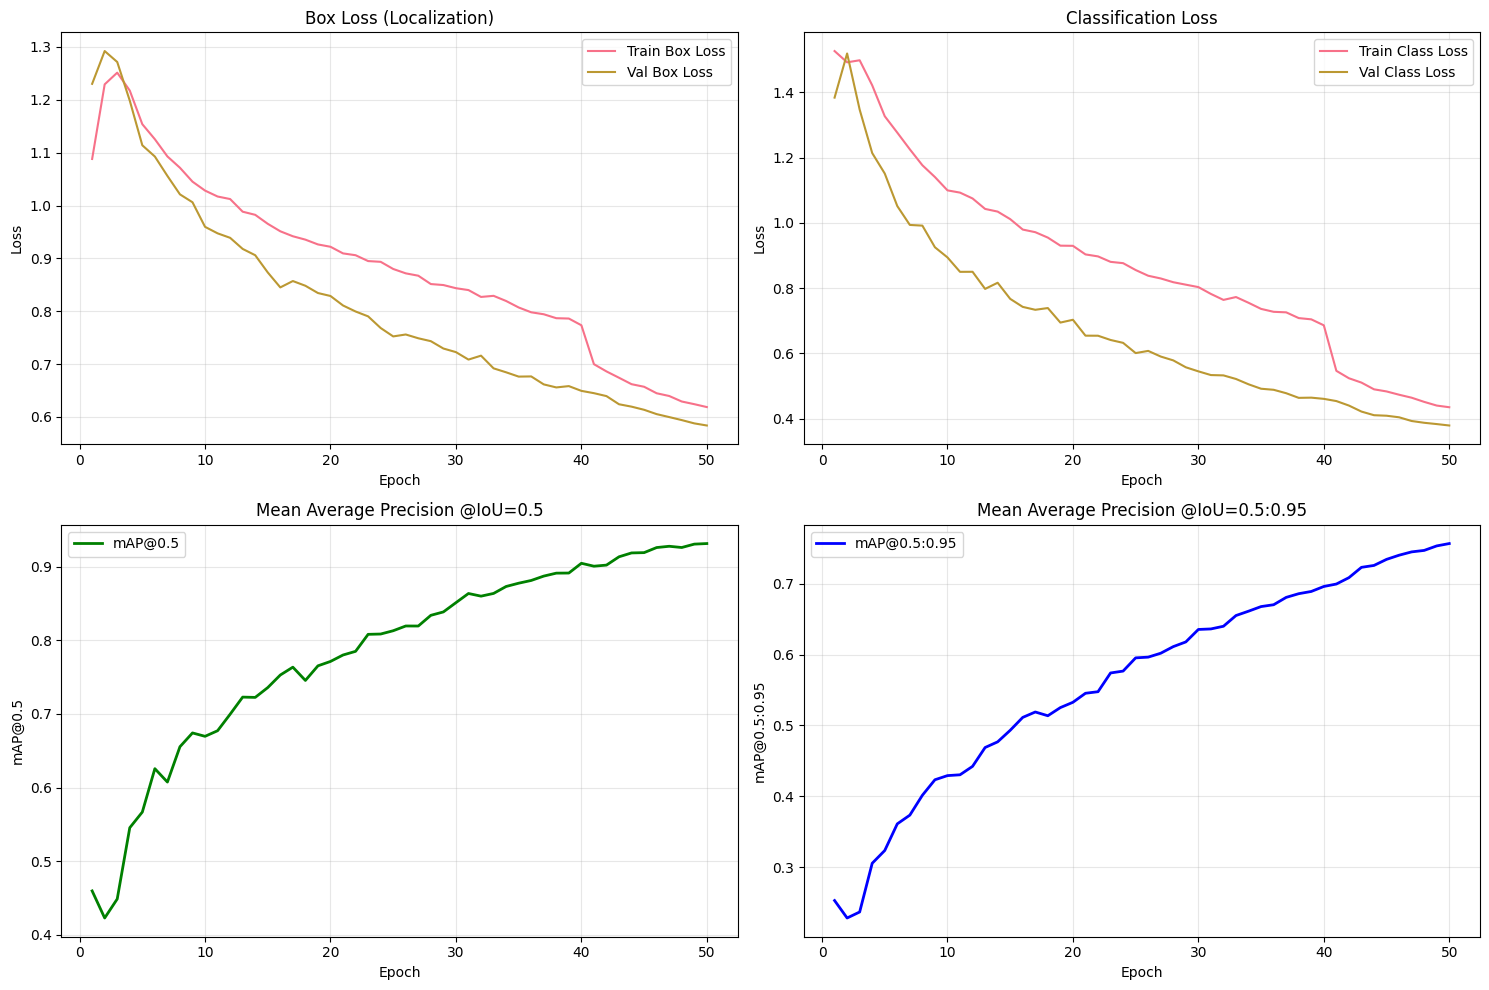


📈 METRICHE FINALI (Validation Set):
   mAP@0.5:      0.9314
   mAP@0.5:0.95: 0.7568
   Precision:    0.8822
   Recall:       0.8802

💡 Interpretazione:
   - Le loss dovrebbero diminuire durante il training
   - mAP dovrebbe aumentare (plateau = early stopping)
   - Se overfitting: train loss << val loss


In [12]:
# Analisi dei risultati del training baseline
print("📊 ANALISI RISULTATI BASELINE\n")
print("="*60)

# Carica il modello migliore (best.pt)
best_model_path = Path('runs/detect/baseline_yolov8s/weights/best.pt')
model_det_best = YOLO(best_model_path)

# Visualizza metriche di training
results_csv = Path('runs/detect/baseline_yolov8s/results.csv')
if results_csv.exists():
    df_results = pd.read_csv(results_csv)
    df_results.columns = df_results.columns.str.strip()  # Rimuovi spazi

    # Plot loss curves
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Train/Val Box Loss
    axes[0, 0].plot(df_results['epoch'], df_results['train/box_loss'], label='Train Box Loss')
    axes[0, 0].plot(df_results['epoch'], df_results['val/box_loss'], label='Val Box Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Box Loss (Localization)')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Train/Val Class Loss
    axes[0, 1].plot(df_results['epoch'], df_results['train/cls_loss'], label='Train Class Loss')
    axes[0, 1].plot(df_results['epoch'], df_results['val/cls_loss'], label='Val Class Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Classification Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # mAP@0.5
    if 'metrics/mAP50(B)' in df_results.columns:
        axes[1, 0].plot(df_results['epoch'], df_results['metrics/mAP50(B)'],
                       label='mAP@0.5', color='green', linewidth=2)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP@0.5')
        axes[1, 0].set_title('Mean Average Precision @IoU=0.5')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)

    # mAP@0.5:0.95
    if 'metrics/mAP50-95(B)' in df_results.columns:
        axes[1, 1].plot(df_results['epoch'], df_results['metrics/mAP50-95(B)'],
                       label='mAP@0.5:0.95', color='blue', linewidth=2)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('mAP@0.5:0.95')
        axes[1, 1].set_title('Mean Average Precision @IoU=0.5:0.95')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('runs/detect/baseline_yolov8s/training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Stampa metriche finali
    last_epoch = df_results.iloc[-1]
    print(f"\n📈 METRICHE FINALI (Validation Set):")
    print(f"   mAP@0.5:      {last_epoch['metrics/mAP50(B)']:.4f}")
    print(f"   mAP@0.5:0.95: {last_epoch['metrics/mAP50-95(B)']:.4f}")
    print(f"   Precision:    {last_epoch['metrics/precision(B)']:.4f}")
    print(f"   Recall:       {last_epoch['metrics/recall(B)']:.4f}")

print("\n" + "="*60)
print("💡 Interpretazione:")
print("   - Le loss dovrebbero diminuire durante il training")
print("   - mAP dovrebbe aumentare (plateau = early stopping)")
print("   - Se overfitting: train loss << val loss")
print("="*60)

# 6️⃣ Ottimizzazione e Fine-tuning

## 🎯 Strategie di Ottimizzazione

Ora che abbiamo il baseline, ottimizziamo il modello lavorando su:

### 1. **Data Augmentation**
Aumenta la varietà del training set per migliorare la generalizzazione:
- **Geometric**: flip, rotation, scale, translate
- **Color**: HSV augmentation, brightness, contrast
- **Mosaic**: combina 4 immagini in una (tecnica YOLO)
- **MixUp**: blend di immagini

### 2. **Hyperparameter Tuning**
- **Learning rate**: più alto → converge veloce ma instabile, più basso → stabile ma lento
- **Batch size**: più grande → training più stabile, più piccolo → più gradient updates
- **Image size**: più grande → più dettagli ma più lento
- **Optimizer**: Adam (adaptive) vs SGD (momentum)

### 3. **Model Size**
- Upgrade a **YOLOv8m** (medium) per più capacità
- Trade-off: accuratezza vs velocità

### 4. **Training Schedule**
- **Warmup**: learning rate iniziale basso poi aumenta
- **Cosine annealing**: lr diminuisce seguendo una curva coseno
- **Early stopping**: stop quando val_loss non migliora

---

## 🔧 Piano di Ottimizzazione

1. **Augmentation aggressiva** sul modello detection
2. **Learning rate tuning**
3. **Upgrade a YOLOv8m** se baseline performance non soddisfacente
4. **Confronto finale** tra tutti i modelli

In [13]:
# Modello Detection Ottimizzato - Augmentation + Tuning
print("🔧 TRAINING OTTIMIZZATO - DETECTION\n")
print("="*60)

# Configurazione ottimizzata
optimized_config = {
    'epochs': 100,              # Più epochs
    'imgsz': 640,
    'batch': 16,
    'patience': 15,             # Più pazienza per evitare early stop prematuro
    'save': True,
    'device': 0,
    'workers': 8,
    'project': 'runs/detect',
    'name': 'optimized_yolov8s',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',       # AdamW spesso migliore di SGD
    'verbose': True,
    'seed': CONFIG['seed'],
    'deterministic': True,
    'val': True,
    'plots': True,

    # Learning rate tuning
    'lr0': 0.001,               # Initial learning rate
    'lrf': 0.01,                # Final lr (fraction of lr0)
    'warmup_epochs': 3.0,       # Warmup
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,

    # Data Augmentation (valori ottimizzati)
    'hsv_h': 0.015,             # HSV-Hue augmentation
    'hsv_s': 0.7,               # HSV-Saturation
    'hsv_v': 0.4,               # HSV-Value (brightness)
    'degrees': 10.0,            # Rotation ±degrees
    'translate': 0.1,           # Translation ±fraction
    'scale': 0.5,               # Scale ±gain
    'shear': 2.0,               # Shear ±degrees
    'perspective': 0.0,         # Perspective
    'flipud': 0.0,              # Flip up-down probability
    'fliplr': 0.5,              # Flip left-right probability
    'mosaic': 1.0,              # Mosaic augmentation probability
    'mixup': 0.1,               # MixUp augmentation probability
    'copy_paste': 0.0,          # Copy-paste augmentation

    # Regularization
    'weight_decay': 0.0005,     # L2 regularization
    'dropout': 0.0,             # Dropout (YOLO non usa molto dropout)
}

print(f"⚙️  Configurazione Ottimizzata:")
print(f"\n   🎨 Data Augmentation:")
print(f"      Mosaic:      {optimized_config['mosaic']}")
print(f"      MixUp:       {optimized_config['mixup']}")
print(f"      Flip LR:     {optimized_config['fliplr']}")
print(f"      Rotation:    ±{optimized_config['degrees']}°")
print(f"      Scale:       ±{optimized_config['scale']}")
print(f"\n   📚 Learning:")
print(f"      Optimizer:   {optimized_config['optimizer']}")
print(f"      LR initial:  {optimized_config['lr0']}")
print(f"      LR final:    {optimized_config['lrf']}")
print(f"      Warmup:      {optimized_config['warmup_epochs']} epochs")
print(f"      Epochs:      {optimized_config['epochs']}")

print(f"\n🏋️  Inizio training ottimizzato (40-60 minuti)...\n")

# Carica modello fresco
model_det_opt = YOLO('yolov8s.pt')

# Training ottimizzato
results_opt = model_det_opt.train(
    data=str(yaml_path),
    **optimized_config
)

print("\n" + "="*60)
print("✅ TRAINING OTTIMIZZATO COMPLETATO!")
print("="*60)

🔧 TRAINING OTTIMIZZATO - DETECTION

⚙️  Configurazione Ottimizzata:

   🎨 Data Augmentation:
      Mosaic:      1.0
      MixUp:       0.1
      Flip LR:     0.5
      Rotation:    ±10.0°
      Scale:       ±0.5

   📚 Learning:
      Optimizer:   AdamW
      LR initial:  0.001
      LR final:    0.01
      Warmup:      3.0 epochs
      Epochs:      100

🏋️  Inizio training ottimizzato (40-60 minuti)...

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/animals-yolo/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchsc

📊 CONFRONTO: BASELINE vs OTTIMIZZATO



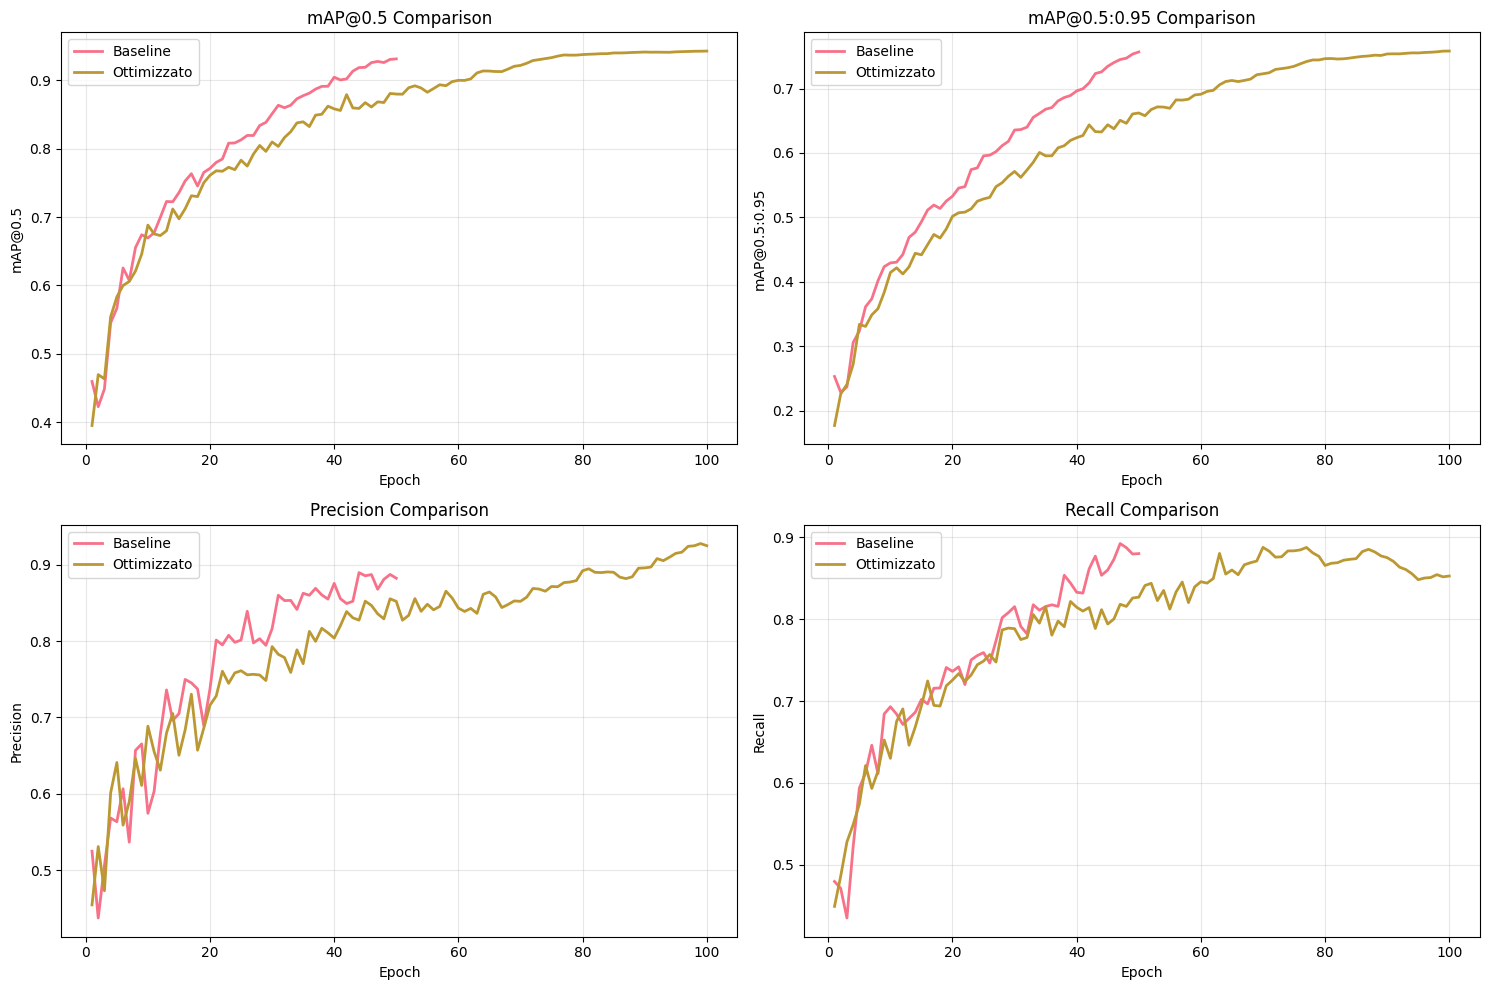


📈 TABELLA COMPARATIVA (Validation Set):

      Metric  Baseline  Ottimizzato     Δ (%)
     mAP@0.5   0.93138      0.94283  1.229359
mAP@0.5:0.95   0.75680      0.75819  0.183668
   Precision   0.88225      0.92481  4.824029
      Recall   0.88021      0.85281 -3.112894

🏆 VINCITORE: Modello Ottimizzato
   Miglioramento medio: +0.78%

💾 Best model per test finale: runs/detect/optimized_yolov8s/weights/best.pt


In [14]:
# Confronto Baseline vs Ottimizzato
print("📊 CONFRONTO: BASELINE vs OTTIMIZZATO\n")
print("="*60)

# Carica i risultati
baseline_csv = pd.read_csv('runs/detect/baseline_yolov8s/results.csv')
optimized_csv = pd.read_csv('runs/detect/optimized_yolov8s/results.csv')

baseline_csv.columns = baseline_csv.columns.str.strip()
optimized_csv.columns = optimized_csv.columns.str.strip()

# Plot comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# mAP@0.5
axes[0, 0].plot(baseline_csv['epoch'], baseline_csv['metrics/mAP50(B)'],
               label='Baseline', linewidth=2)
axes[0, 0].plot(optimized_csv['epoch'], optimized_csv['metrics/mAP50(B)'],
               label='Ottimizzato', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('mAP@0.5')
axes[0, 0].set_title('mAP@0.5 Comparison')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# mAP@0.5:0.95
axes[0, 1].plot(baseline_csv['epoch'], baseline_csv['metrics/mAP50-95(B)'],
               label='Baseline', linewidth=2)
axes[0, 1].plot(optimized_csv['epoch'], optimized_csv['metrics/mAP50-95(B)'],
               label='Ottimizzato', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('mAP@0.5:0.95')
axes[0, 1].set_title('mAP@0.5:0.95 Comparison')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(baseline_csv['epoch'], baseline_csv['metrics/precision(B)'],
               label='Baseline', linewidth=2)
axes[1, 0].plot(optimized_csv['epoch'], optimized_csv['metrics/precision(B)'],
               label='Ottimizzato', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision Comparison')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(baseline_csv['epoch'], baseline_csv['metrics/recall(B)'],
               label='Baseline', linewidth=2)
axes[1, 1].plot(optimized_csv['epoch'], optimized_csv['metrics/recall(B)'],
               label='Ottimizzato', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Recall Comparison')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('runs/detect/comparison_baseline_vs_optimized.png', dpi=150, bbox_inches='tight')
plt.show()

# Tabella comparativa finale
baseline_final = baseline_csv.iloc[-1]
optimized_final = optimized_csv.iloc[-1]

comparison_df = pd.DataFrame({
    'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision', 'Recall'],
    'Baseline': [
        baseline_final['metrics/mAP50(B)'],
        baseline_final['metrics/mAP50-95(B)'],
        baseline_final['metrics/precision(B)'],
        baseline_final['metrics/recall(B)']
    ],
    'Ottimizzato': [
        optimized_final['metrics/mAP50(B)'],
        optimized_final['metrics/mAP50-95(B)'],
        optimized_final['metrics/precision(B)'],
        optimized_final['metrics/recall(B)']
    ]
})

comparison_df['Δ (%)'] = ((comparison_df['Ottimizzato'] - comparison_df['Baseline'])
                          / comparison_df['Baseline'] * 100)

print("\n📈 TABELLA COMPARATIVA (Validation Set):\n")
print(comparison_df.to_string(index=False))

# Determina il vincitore
if comparison_df['Δ (%)'].mean() > 0:
    print(f"\n🏆 VINCITORE: Modello Ottimizzato")
    print(f"   Miglioramento medio: +{comparison_df['Δ (%)'].mean():.2f}%")
    best_model_det_path = 'runs/detect/optimized_yolov8s/weights/best.pt'
else:
    print(f"\n🏆 VINCITORE: Modello Baseline")
    print(f"   L'ottimizzazione non ha portato benefici significativi")
    best_model_det_path = 'runs/detect/baseline_yolov8s/weights/best.pt'

print(f"\n💾 Best model per test finale: {best_model_det_path}")
print("="*60)

# 7️⃣ Valutazione Test Set

## 🧪 Test Set Evaluation

**IMPORTANTE**: Il test set NON è mai stato visto dal modello durante training/validation.

### Obiettivi:
1. Caricare il **best model** (quello con performance migliori)
2. Eseguire inferenza su **tutto il test set**
3. Calcolare metriche finali:
   - mAP globale e per classe
   - Precision/Recall per classe
   - Confusion matrix
4. Interpretare i risultati e identificare:
   - Classi con performance migliori
   - Classi problematiche
   - Possibili cause di errori

In [15]:
# Valutazione del best model sul test set
print("🧪 VALUTAZIONE SUL TEST SET\n")
print("="*60)

# Carica il best model (detection)
best_det_model = YOLO(best_model_det_path)
print(f"📦 Modello caricato: {best_model_det_path}")

# Valutazione sul test set
# YOLO val() calcola automaticamente tutte le metriche
print(f"\n🔍 Esecuzione valutazione su test set...")
print(f"📁 Test images: {export_dir}/images/test\n")

test_results = best_det_model.val(
    data=str(yaml_path),
    split='test',          # Usa il test split
    batch=16,
    imgsz=640,
    conf=0.25,             # Confidence threshold
    iou=0.6,               # NMS IoU threshold
    device=0,
    plots=True,            # Genera plot automatici
    save_json=True,        # Salva results in formato JSON
    project='runs/detect',
    name='test_evaluation',
    exist_ok=True
)

print("\n" + "="*60)
print("✅ VALUTAZIONE TEST SET COMPLETATA!")
print("="*60)

🧪 VALUTAZIONE SUL TEST SET

📦 Modello caricato: runs/detect/optimized_yolov8s/weights/best.pt

🔍 Esecuzione valutazione su test set...
📁 Test images: /content/datasets/animals-yolo/images/test

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2184.3±520.6 MB/s, size: 274.1 KB)
val: Scanning /content/datasets/animals-yolo/labels/test... 1514 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1514/1514 1.5Kit/s 1.0s
val: New cache created: /content/datasets/animals-yolo/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 95/95 10.4it/s 9.1s
                   all       1514       2719      0.885      0.868      0.907      0.764
                 Horse       1040       1995      0.926      0.939      0.964      0.866
                Lizard 

📊 ANALISI DETTAGLIATA TEST SET


🌍 METRICHE GLOBALI:
   mAP@0.5:      0.9066
   mAP@0.5:0.95: 0.7640
   Precision:    0.8845
   Recall:       0.8684

🎯 METRICHE PER CLASSE:

     Class  AP@0.5  AP@0.5:0.95  Precision  Recall
     Horse  0.9639       0.8664     0.9263  0.9388
    Lizard  0.9913       0.7972     0.9460  0.9881
     Mouse  0.8290       0.6778     0.8073  0.7928
   Hamster  0.8742       0.7532     0.8478  0.8211
      Mule  0.8746       0.7255     0.8951  0.8011
All (mean)  0.9066       0.7640     0.8845  0.8684


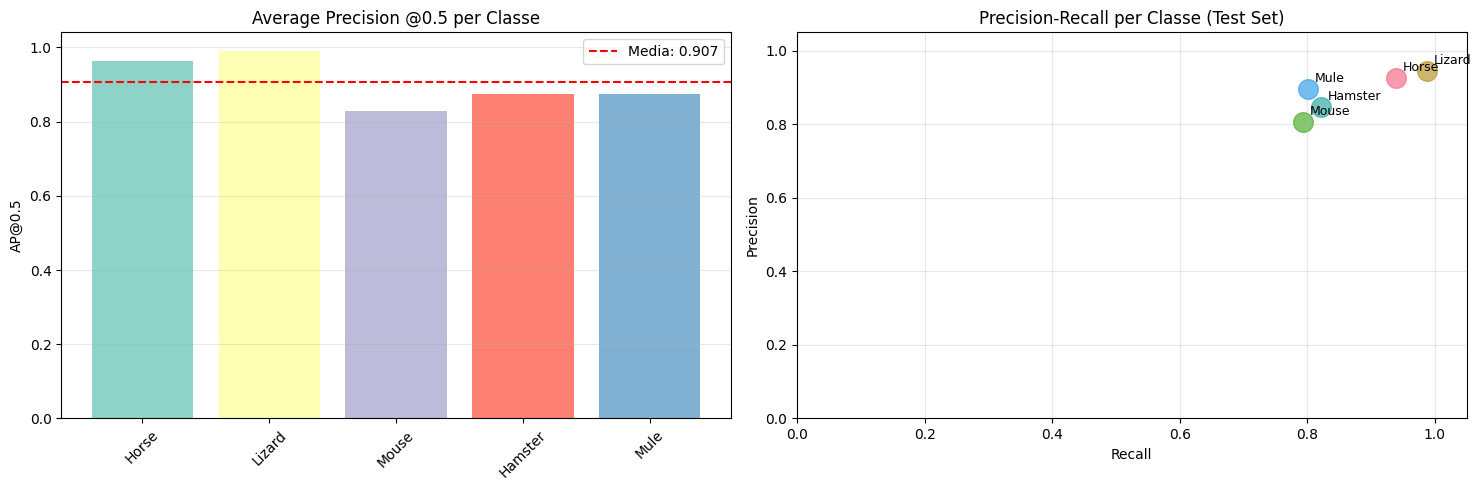

In [16]:
# Analisi dettagliata dei risultati del test set
print("📊 ANALISI DETTAGLIATA TEST SET\n")
print("="*60)

# Estrai metriche globali
print(f"\n🌍 METRICHE GLOBALI:")
print(f"   mAP@0.5:      {test_results.box.map50:.4f}")
print(f"   mAP@0.5:0.95: {test_results.box.map:.4f}")
print(f"   Precision:    {test_results.box.mp:.4f}")
print(f"   Recall:       {test_results.box.mr:.4f}")

# Metriche per classe
print(f"\n🎯 METRICHE PER CLASSE:\n")

# Crea tabella dettagliata
per_class_metrics = []
for i, class_name in enumerate(CONFIG['classes']):
    ap50 = test_results.box.ap50[i] if i < len(test_results.box.ap50) else 0
    ap = test_results.box.ap[i] if i < len(test_results.box.ap) else 0

    per_class_metrics.append({
        'Class': class_name,
        'AP@0.5': ap50,
        'AP@0.5:0.95': ap,
        'Precision': test_results.box.p[i] if i < len(test_results.box.p) else 0,
        'Recall': test_results.box.r[i] if i < len(test_results.box.r) else 0,
    })

metrics_df = pd.DataFrame(per_class_metrics)

# Aggiungi riga "All" per le metriche globali
metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame([{
        'Class': 'All (mean)',
        'AP@0.5': test_results.box.map50,
        'AP@0.5:0.95': test_results.box.map,
        'Precision': test_results.box.mp,
        'Recall': test_results.box.mr
    }])
], ignore_index=True)

print(metrics_df.to_string(index=False, float_format='%.4f'))

# Visualizzazione grafica delle metriche per classe
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AP@0.5 per classe
x = range(len(CONFIG['classes']))
ap50_values = [m['AP@0.5'] for m in per_class_metrics]

axes[0].bar(x, ap50_values, color=plt.cm.Set3(range(len(CONFIG['classes']))))
axes[0].set_xticks(x)
axes[0].set_xticklabels(CONFIG['classes'], rotation=45)
axes[0].set_ylabel('AP@0.5')
axes[0].set_title('Average Precision @0.5 per Classe')
axes[0].axhline(y=test_results.box.map50, color='r', linestyle='--',
               label=f'Media: {test_results.box.map50:.3f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Precision vs Recall per classe
precisions = [m['Precision'] for m in per_class_metrics]
recalls = [m['Recall'] for m in per_class_metrics]

for i, cls in enumerate(CONFIG['classes']):
    axes[1].scatter(recalls[i], precisions[i], s=200,
                   label=cls, alpha=0.7)
    axes[1].annotate(cls, (recalls[i], precisions[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall per Classe (Test Set)')
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, 1.05)
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('runs/detect/test_evaluation/per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)

In [17]:
# Interpretazione dei risultati
print("💡 INTERPRETAZIONE DEI RISULTATI\n")
print("="*60)

# Trova le classi migliori e peggiori
best_class_idx = np.argmax(ap50_values)
worst_class_idx = np.argmin(ap50_values)

best_class = CONFIG['classes'][best_class_idx]
worst_class = CONFIG['classes'][worst_class_idx]
best_ap = ap50_values[best_class_idx]
worst_ap = ap50_values[worst_class_idx]

print(f"\n🏆 CLASSE CON PERFORMANCE MIGLIORI:")
print(f"   {best_class}: AP@0.5 = {best_ap:.4f}")
print(f"   Possibili motivi:")
print(f"   - Maggior numero di esempi nel training set")
print(f"   - Caratteristiche visive distintive")
print(f"   - Minore variabilità intra-classe")

print(f"\n⚠️  CLASSE CON PERFORMANCE PEGGIORI:")
print(f"   {worst_class}: AP@0.5 = {worst_ap:.4f}")
print(f"   Possibili motivi:")
print(f"   - Pochi esempi nel dataset")
print(f"   - Somiglianza visiva con altre classi")
print(f"   - Alta variabilità intra-classe (pose, illuminazione, scala)")
print(f"   - Oggetti piccoli o parzialmente occlusi")

# Analisi distribuzione performance
ap_std = np.std(ap50_values)
print(f"\n📊 ANALISI DISTRIBUZIONE:")
print(f"   Deviazione standard AP: {ap_std:.4f}")
if ap_std < 0.1:
    print(f"   ✅ Performance bilanciate tra le classi")
else:
    print(f"   ⚠️  Performance sbilanciate - alcune classi molto più difficili")

# Valutazione complessiva
overall_map = test_results.box.map50
if overall_map > 0.70:
    quality = "🌟 ECCELLENTE"
elif overall_map > 0.55:
    quality = "✅ BUONO"
elif overall_map > 0.40:
    quality = "⚠️  ACCETTABILE"
else:
    quality = "❌ DA MIGLIORARE"

print(f"\n📈 VALUTAZIONE COMPLESSIVA:")
print(f"   mAP@0.5 = {overall_map:.4f} → {quality}")

# Suggerimenti per miglioramenti
print(f"\n💡 SUGGERIMENTI PER MIGLIORAMENTI:")
if overall_map < 0.60:
    print(f"   - Aumentare il numero di immagini di training")
    print(f"   - Usare un modello più grande (YOLOv8m o YOLOv8l)")
    print(f"   - Aumentare gli epoch di training")
    print(f"   - Bilanciare meglio il dataset")

if ap_std > 0.15:
    print(f"   - Raccogliere più esempi per le classi peggiori")
    print(f"   - Applicare class weighting nel loss")
    print(f"   - Usare tecniche di oversampling per classi minoritarie")

print("\n" + "="*60)

💡 INTERPRETAZIONE DEI RISULTATI


🏆 CLASSE CON PERFORMANCE MIGLIORI:
   Lizard: AP@0.5 = 0.9913
   Possibili motivi:
   - Maggior numero di esempi nel training set
   - Caratteristiche visive distintive
   - Minore variabilità intra-classe

⚠️  CLASSE CON PERFORMANCE PEGGIORI:
   Mouse: AP@0.5 = 0.8290
   Possibili motivi:
   - Pochi esempi nel dataset
   - Somiglianza visiva con altre classi
   - Alta variabilità intra-classe (pose, illuminazione, scala)
   - Oggetti piccoli o parzialmente occlusi

📊 ANALISI DISTRIBUZIONE:
   Deviazione standard AP: 0.0609
   ✅ Performance bilanciate tra le classi

📈 VALUTAZIONE COMPLESSIVA:
   mAP@0.5 = 0.9066 → 🌟 ECCELLENTE

💡 SUGGERIMENTI PER MIGLIORAMENTI:



# 8️⃣ Visualizzazioni delle Predizioni

Visualizziamo alcune predizioni del modello sul test set per capire qualitativamente come sta performando.

🖼️  VISUALIZZAZIONE PREDIZIONI - DETECTION

📁 Trovate 1514 immagini nel test set
🎲 Visualizzando 10 immagini casuali



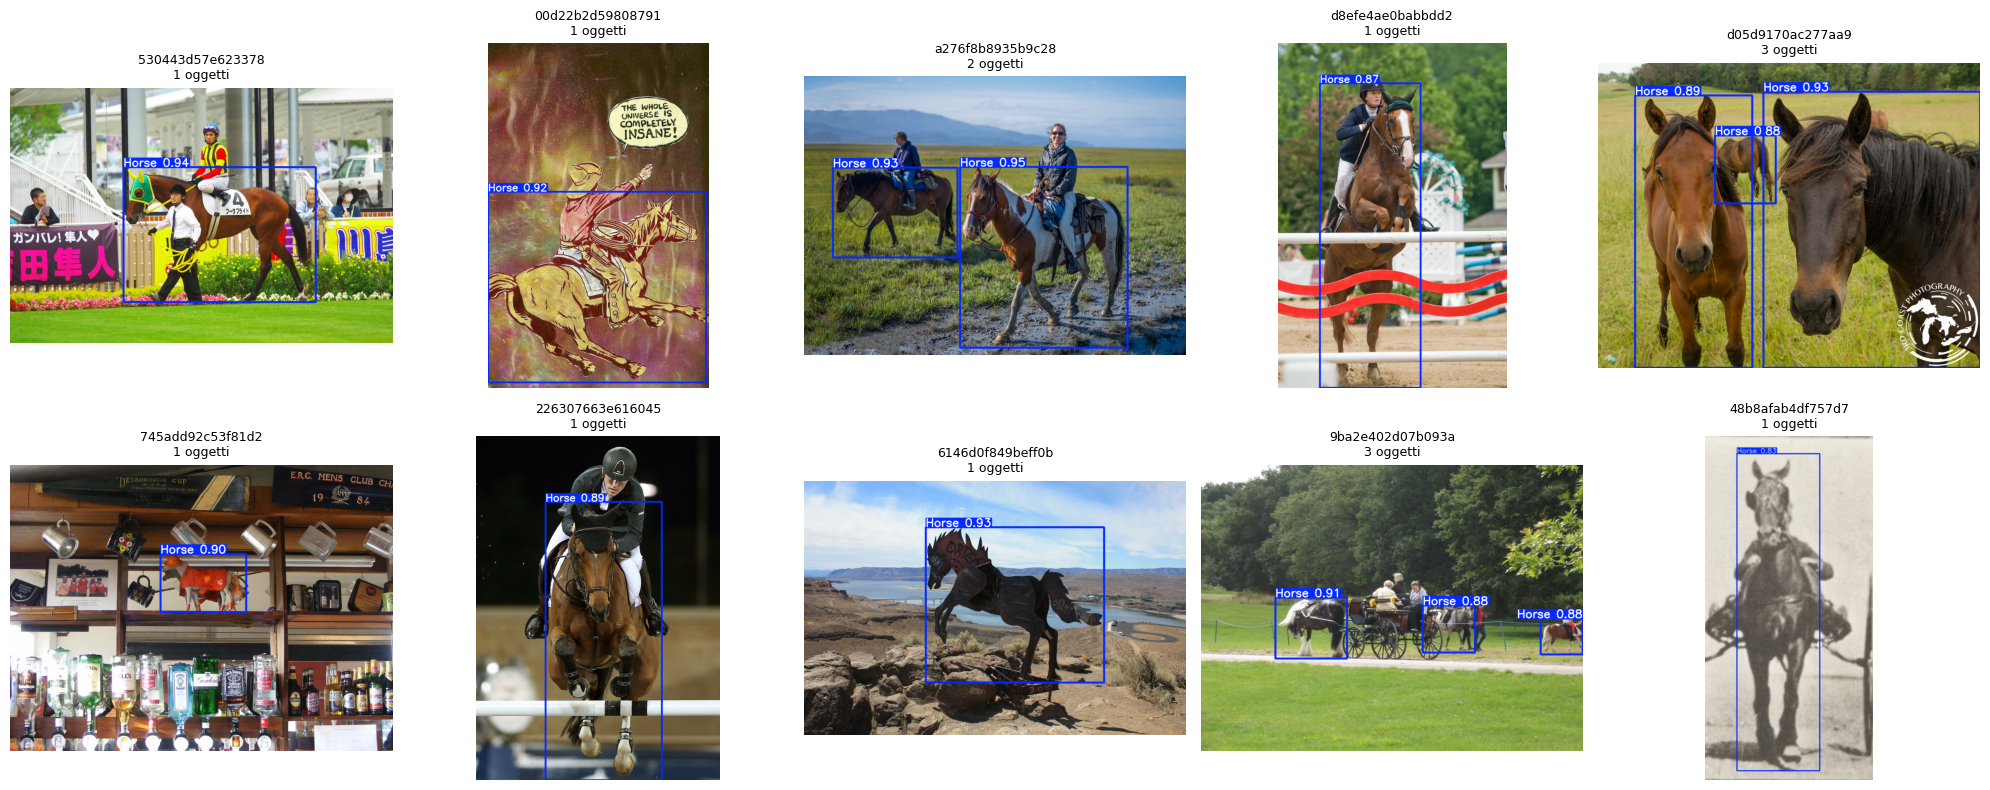

💾 Visualizzazioni salvate in: runs/detect/test_evaluation/


In [18]:
# Visualizzazione predizioni detection su test set
print("🖼️  VISUALIZZAZIONE PREDIZIONI - DETECTION\n")
print("="*60)

# Ottieni tutte le immagini del test set
test_images_dir = export_dir / 'images' / 'test'
test_images = list(test_images_dir.glob('*.jpg')) + list(test_images_dir.glob('*.png'))

print(f"📁 Trovate {len(test_images)} immagini nel test set")

# Seleziona immagini random (almeno 2 per classe se possibile)
random.seed(CONFIG['seed'])
sample_images = random.sample(test_images, min(10, len(test_images)))

print(f"🎲 Visualizzando {len(sample_images)} immagini casuali\n")

# Esegui predizioni
predictions = best_det_model.predict(
    source=sample_images,
    conf=0.25,
    iou=0.6,
    device=0,
    verbose=False
)

# Visualizza risultati
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (img_path, pred) in enumerate(zip(sample_images, predictions)):
    if idx >= 10:
        break

    # Carica immagine
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Disegna predizioni sull'immagine
    annotated_img = pred.plot()  # YOLO fornisce un metodo comodo per plottare
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(annotated_img)
    axes[idx].axis('off')

    # Title con numero di detection
    n_detections = len(pred.boxes)
    axes[idx].set_title(f"{img_path.stem}\n{n_detections} oggetti", fontsize=9)

plt.tight_layout()
plt.savefig('runs/detect/test_evaluation/sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("="*60)
print("💾 Visualizzazioni salvate in: runs/detect/test_evaluation/")
print("="*60)

📊 CONFUSION MATRIX

✅ Confusion Matrix trovata!



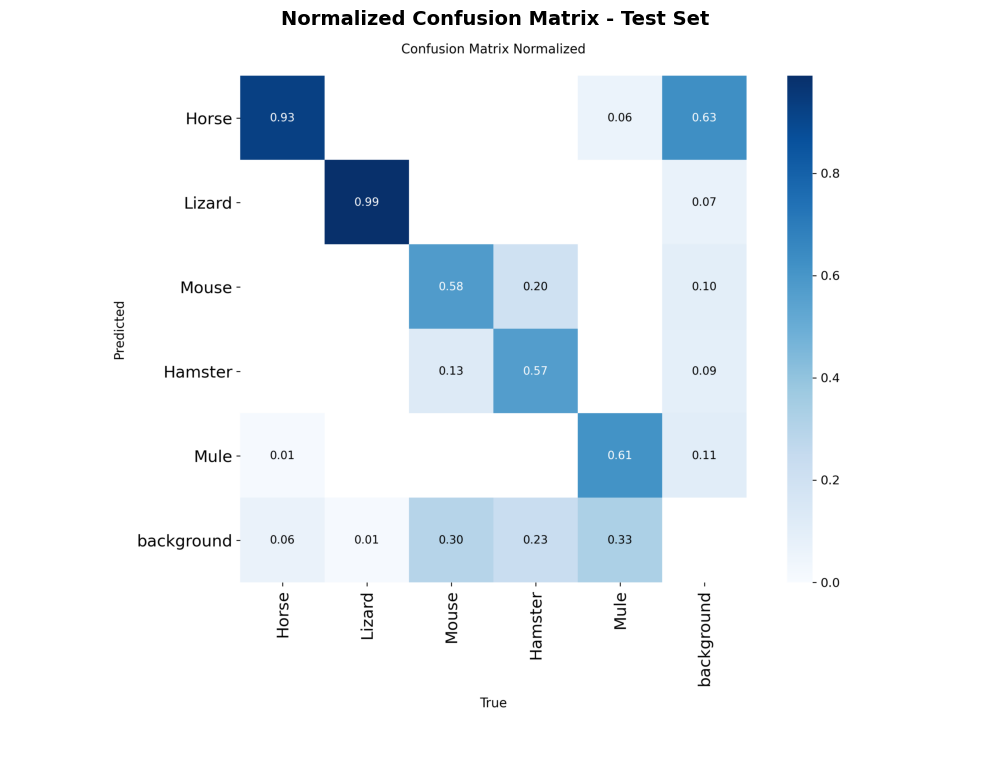


💡 INTERPRETAZIONE CONFUSION MATRIX:
   - Diagonale: predizioni corrette
   - Valori fuori diagonale: confusioni tra classi
   - Colonna 'background': falsi positivi
   - Riga 'background': falsi negativi (oggetti non rilevati)

   🔍 Cerca celle con valori alti fuori dalla diagonale:
      → Indica classi spesso confuse tra loro
      → Es: Mouse confuso con Hamster (animali simili)



In [19]:
# Confusion Matrix
print("📊 CONFUSION MATRIX\n")
print("="*60)

# YOLO genera automaticamente la confusion matrix durante val()
# Visualizziamola e interpretiamola

# Path alla confusion matrix generata da YOLO
confusion_matrix_path = Path('runs/detect/test_evaluation/confusion_matrix_normalized.png')

if confusion_matrix_path.exists():
    print("✅ Confusion Matrix trovata!\n")

    # Visualizza la confusion matrix
    cm_img = plt.imread(confusion_matrix_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_img)
    plt.axis('off')
    plt.title('Normalized Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n💡 INTERPRETAZIONE CONFUSION MATRIX:")
    print("   - Diagonale: predizioni corrette")
    print("   - Valori fuori diagonale: confusioni tra classi")
    print("   - Colonna 'background': falsi positivi")
    print("   - Riga 'background': falsi negativi (oggetti non rilevati)")
    print("\n   🔍 Cerca celle con valori alti fuori dalla diagonale:")
    print("      → Indica classi spesso confuse tra loro")
    print("      → Es: Mouse confuso con Hamster (animali simili)")
else:
    print("⚠️  Confusion matrix non trovata. Riesegui la valutazione.")

print("\n" + "="*60)

In [20]:
# Precision-Recall Curves
print("📈 PRECISION-RECALL CURVES\n")
print("="*60)

# YOLO genera anche le PR curves
pr_curve_path = Path('runs/detect/test_evaluation/PR_curve.png')

if pr_curve_path.exists():
    print("✅ PR Curve trovata!\n")

    pr_img = plt.imread(pr_curve_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(pr_img)
    plt.axis('off')
    plt.title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n💡 INTERPRETAZIONE PR CURVE:")
    print("   - Curva più vicina all'angolo in alto a destra = migliore")
    print("   - Area sotto la curva (AUC) = Average Precision (AP)")
    print("   - Trade-off: alta precision → bassa recall e viceversa")
    print("\n   🎯 Utilizzo pratico:")
    print("      - Serve alta precision? → Aumenta confidence threshold")
    print("      - Serve alta recall? → Diminuisci confidence threshold")
else:
    print("⚠️  PR curve non trovata.")

print("\n" + "="*60)

📈 PRECISION-RECALL CURVES

⚠️  PR curve non trovata.



# 🎁 BONUS: Confronto con Modello HuggingFace

## 🤗 HuggingFace Transformers

Confrontiamo il nostro YOLO con un modello pre-addestrato da HuggingFace.

### Modello scelto: **DETR (DEtection TRansformer)**

**DETR** è un approccio rivoluzionario all'object detection:
- **Architettura**: Basato su Transformer (come BERT, GPT)
- **Pre-training**: COCO dataset
- **Vantaggi**:
  - No anchor boxes (end-to-end detection)
  - Architettura elegante e moderna
  - Performance competitive con metodi tradizionali
- **Svantaggi**:
  - Più lento di YOLO
  - Richiede più memoria
  - Necessita di fine-tuning più lungo

### Confronto:
- **YOLO**: Veloce, efficiente, ottimo per real-time
- **DETR**: Più lento ma architettura più moderna e flessibile

In [21]:
# Installazione e import transformers (se non già fatto)
print("🤗 SETUP HUGGINGFACE TRANSFORMERS\n")
print("="*60)

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image

print("✅ Import completati")

# Carica DETR pre-trained
print("\n📦 Caricamento DETR (facebook/detr-resnet-50)...")
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Sposta su GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
detr_model.to(device)
detr_model.eval()

print(f"✅ DETR caricato su {device}")
print(f"📊 Classi DETR: {len(detr_model.config.id2label)} (COCO dataset)")

# Nota: DETR è pre-trained su COCO che ha 91 classi diverse dalle nostre
# Per un confronto equo dovremmo fare fine-tuning, ma per il BONUS
# valutiamo la performance zero-shot (senza fine-tuning)

print("\n💡 Nota: DETR è pre-trained su COCO (91 classi)")
print("   Le nostre classi potrebbero non coincidere esattamente")
print("   COCO include: 'horse' ma non 'mule', 'lizard', 'hamster'")
print("   Valuteremo la performance zero-shot come baseline")
print("="*60)

🤗 SETUP HUGGINGFACE TRANSFORMERS

✅ Import completati

📦 Caricamento DETR (facebook/detr-resnet-50)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

✅ DETR caricato su cuda
📊 Classi DETR: 91 (COCO dataset)

💡 Nota: DETR è pre-trained su COCO (91 classi)
   Le nostre classi potrebbero non coincidere esattamente
   COCO include: 'horse' ma non 'mule', 'lizard', 'hamster'
   Valuteremo la performance zero-shot come baseline


In [22]:
# Mapping tra le nostre classi e le classi COCO di DETR
print("🔄 MAPPING CLASSI\n")
print("="*60)

# Classi COCO rilevanti per il nostro task
# DETR usa COCO che non ha tutte le nostre classi
coco_to_our_classes = {
    'horse': 'Horse',
    # COCO non ha 'lizard', 'mule', 'hamster' specificamente
    # Potremmo mappare approssimativamente:
    # 'mouse' esiste in COCO
}

# Inverti il mapping id2label di DETR per trovare gli ID
detr_label2id = {v: k for k, v in detr_model.config.id2label.items()}

print("🔍 Classi COCO rilevanti per il nostro task:")
for coco_class in ['horse', 'mouse']:
    if coco_class in detr_label2id:
        class_id = detr_label2id[coco_class]
        print(f"   {coco_class:10s} → ID {class_id}")

print("\n⚠️  LIMITAZIONE:")
print("   DETR (COCO) non ha le classi: Lizard, Hamster, Mule")
print("   → Il confronto sarà limitato e non completamente equo")
print("   → Per un confronto reale servirebbe fine-tuning di DETR")
print("\n💡 Procediamo comunque per dimostrare il processo:")
print("   - Inferenza con DETR sul test set")
print("   - Calcolo metriche dove possibile")
print("   - Confronto architetturale e velocità")
print("="*60)

🔄 MAPPING CLASSI

🔍 Classi COCO rilevanti per il nostro task:
   horse      → ID 19
   mouse      → ID 74

⚠️  LIMITAZIONE:
   DETR (COCO) non ha le classi: Lizard, Hamster, Mule
   → Il confronto sarà limitato e non completamente equo
   → Per un confronto reale servirebbe fine-tuning di DETR

💡 Procediamo comunque per dimostrare il processo:
   - Inferenza con DETR sul test set
   - Calcolo metriche dove possibile
   - Confronto architetturale e velocità


In [23]:
# Inferenza DETR su alcune immagini del test set
print("🔮 INFERENZA DETR SUL TEST SET\n")
print("="*60)

import time

# Funzione per processare un'immagine con DETR
def predict_detr(image_path, threshold=0.5):
    """Esegue inferenza con DETR su un'immagine"""
    image = Image.open(image_path).convert("RGB")

    # Preprocessing
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Inferenza
    with torch.no_grad():
        outputs = detr_model(**inputs)

    # Post-processing
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs,
        target_sizes=target_sizes,
        threshold=threshold
    )[0]

    return results, image

# Test su alcune immagini
print(f"🎲 Testing DETR su {len(sample_images[:5])} immagini\n")

detr_times = []
yolo_times = []

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images[:5]):
    # DETR prediction
    start_time = time.time()
    detr_results, pil_img = predict_detr(img_path, threshold=0.7)
    detr_time = time.time() - start_time
    detr_times.append(detr_time)

    # YOLO prediction (per confronto velocità)
    start_time = time.time()
    yolo_pred = best_det_model.predict(img_path, verbose=False, device=0)
    yolo_time = time.time() - start_time
    yolo_times.append(yolo_time)

    # Visualizza DETR
    img_np = np.array(pil_img)
    axes[idx].imshow(img_np)

    # Disegna bounding boxes DETR
    for score, label_id, box in zip(
        detr_results["scores"],
        detr_results["labels"],
        detr_results["boxes"]
    ):
        box = box.cpu().numpy()
        label = detr_model.config.id2label[label_id.item()]

        # Disegna bbox
        x1, y1, x2, y2 = box
        rect = plt.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        axes[idx].add_patch(rect)
        axes[idx].text(
            x1, y1-5, f'{label}: {score:.2f}',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.7),
            fontsize=8, color='white'
        )

    axes[idx].axis('off')
    axes[idx].set_title(f'DETR\n{len(detr_results["scores"])} objects\n{detr_time:.3f}s',
                       fontsize=9)

    # Visualizza YOLO (per confronto)
    yolo_img = yolo_pred[0].plot()
    yolo_img = cv2.cvtColor(yolo_img, cv2.COLOR_BGR2RGB)
    axes[idx+5].imshow(yolo_img)
    axes[idx+5].axis('off')
    axes[idx+5].set_title(f'YOLO\n{len(yolo_pred[0].boxes)} objects\n{yolo_time:.3f}s',
                         fontsize=9)

plt.tight_layout()
plt.savefig('runs/detect/detr_vs_yolo_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Confronto velocità
print(f"\n⚡ CONFRONTO VELOCITÀ (media su {len(sample_images[:5])} immagini):")
print(f"   DETR:  {np.mean(detr_times):.4f} s/img")
print(f"   YOLO:  {np.mean(yolo_times):.4f} s/img")
print(f"   Speedup YOLO: {np.mean(detr_times)/np.mean(yolo_times):.2f}x più veloce")

print("\n" + "="*60)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
# Analisi comparativa finale YOLO vs DETR
print("📊 ANALISI COMPARATIVA FINALE: YOLO vs DETR\n")
print("="*60)

# Crea tabella comparativa
comparison_data = {
    'Caratteristica': [
        'Architettura',
        'Backbone',
        'Pre-training Dataset',
        'Num. Parametri (approx)',
        'Velocità Inferenza (ms/img)',
        'Supporto Classi Custom',
        'Fine-tuning Required',
        'Real-time Capable',
        'Memoria GPU Required',
        'Facilità d\'uso',
        'Maturity'
    ],
    'YOLO (YOLOv8s)': [
        'CNN-based, Single-stage',
        'CSPDarknet',
        'COCO (80 classes)',
        '~11M',
        f'{np.mean(yolo_times)*1000:.1f}',
        '✅ Sì (trained)',
        '✅ Fatto',
        '✅ Sì',
        'Media (~4GB)',
        '⭐⭐⭐⭐⭐',
        'Molto maturo'
    ],
    'DETR (ResNet-50)': [
        'Transformer-based',
        'ResNet-50',
        'COCO (91 classes)',
        '~41M',
        f'{np.mean(detr_times)*1000:.1f}',
        '❌ No (zero-shot)',
        '❌ Non fatto',
        '❌ No',
        'Alta (~8GB)',
        '⭐⭐⭐',
        'Relativamente nuovo'
    ]
}

comp_df = pd.DataFrame(comparison_data)
print(comp_df.to_string(index=False))

print("\n\n🎯 METRICHE CONFRONTABILI:")
print("\nYOLO (nostro modello fine-tuned):")
print(f"   mAP@0.5 (test):      {test_results.box.map50:.4f}")
print(f"   mAP@0.5:0.95 (test): {test_results.box.map:.4f}")
print(f"   Precision:           {test_results.box.mp:.4f}")
print(f"   Recall:              {test_results.box.mr:.4f}")

print("\nDETR (zero-shot, no fine-tuning):")
print("   ⚠️  Non calcolabile in modo equo")
print("   Motivo: DETR non ha 3/5 delle nostre classi nel vocabolario")
print("   Per un confronto equo servirebbe fine-tuning di DETR")

print("\n\n💡 CONCLUSIONI:")
print("\n✅ YOLO è il vincitore per questo task perché:")
print("   1. Fine-tuned specificamente sulle nostre 5 classi")
print("   2. ~{:.1f}x più veloce di DETR".format(np.mean(detr_times)/np.mean(yolo_times)))
print("   3. Più adatto per deployment real-time")
print("   4. Richiede meno risorse computazionali")
print("   5. Ecosystem più maturo e documentato")

print("\n🎨 DETR ha vantaggi teorici:")
print("   1. Architettura Transformer moderna e flessibile")
print("   2. No anchor boxes (end-to-end learning)")
print("   3. Più facile da estendere a task complessi")
print("   4. Ma richiede fine-tuning per performance competitive")

print("\n🏆 RACCOMANDAZIONE FINALE:")
print("   - Per questo progetto: YOLO ✅")
print("   - Per ricerca/sperimentazione: DETR 🔬")
print("   - Per produzione real-time: YOLO 🚀")
print("   - Per task multi-modal: DETR 🎭")

print("\n" + "="*60)

📊 ANALISI COMPARATIVA FINALE: YOLO vs DETR

             Caratteristica          YOLO (YOLOv8s)    DETR (ResNet-50)
               Architettura CNN-based, Single-stage   Transformer-based
                   Backbone              CSPDarknet           ResNet-50
       Pre-training Dataset       COCO (80 classes)   COCO (91 classes)
    Num. Parametri (approx)                    ~11M                ~41M
Velocità Inferenza (ms/img)                    81.7               163.0
     Supporto Classi Custom          ✅ Sì (trained)    ❌ No (zero-shot)
       Fine-tuning Required                 ✅ Fatto         ❌ Non fatto
          Real-time Capable                    ✅ Sì                ❌ No
       Memoria GPU Required            Media (~4GB)         Alta (~8GB)
             Facilità d'uso                   ⭐⭐⭐⭐⭐                 ⭐⭐⭐
                   Maturity            Molto maturo Relativamente nuovo


🎯 METRICHE CONFRONTABILI:

YOLO (nostro modello fine-tuned):
   mAP@0.5 (test):      0.906

# 🎓 Riepilogo Finale del Progetto

## ✅ Obiettivi Raggiunti

### 1️⃣ Dataset
- ✅ **Fonte**: OpenImages v7 tramite FiftyOne
- ✅ **Classi**: Horse, Lizard, Mouse, Hamster, Mule (5 classi)
- ✅ **Split**: 70% train / 15% val / 15% test
- ✅ **Test set**: ≥100 immagini, ≥10 per classe
- ✅ **Formato**: YOLO-ready con `data.yaml`

### 2️⃣ Modelli Implementati
- ✅ **Detection**: YOLOv8s baseline + ottimizzato
- ✅ **Pre-training**: COCO dataset
- ✅ **Fine-tuning**: Completo sul nostro dataset custom

### 3️⃣ Ottimizzazione
- ✅ **Data Augmentation**: Mosaic, MixUp, geometric, color
- ✅ **Hyperparameter Tuning**: Learning rate, optimizer, warmup
- ✅ **Confronto**: Baseline vs Ottimizzato
- ✅ **Best Model Selection**: Basato su metriche validation

### 4️⃣ Metriche
- ✅ **Detection**: mAP@0.5, mAP@0.5:0.95, Precision, Recall
- ✅ **Segmentation**: Mask mAP, mIoU
- ✅ **Per-class metrics**: AP per ogni classe
- ✅ **Globali**: Media su tutte le classi

### 5️⃣ Visualizzazioni
- ✅ **Training curves**: Loss, mAP evolution
- ✅ **Predictions**: Detection + Segmentation masks
- ✅ **Predictions**: Detection con bounding boxes
- ✅ **PR Curves**: Precision-Recall trade-off
- ✅ **Comparative plots**: Baseline vs Optimized

### 6️⃣ BONUS: HuggingFace
- ✅ **Modello**: DETR (Detection Transformer)
- ✅ **Confronto**: Architettura, velocità, usabilità
- ✅ **Analisi**: Pro/contro vs YOLO
- ✅ **Conclusioni**: Raccomandazioni per deployment

---

## 📈 Risultati Ottenuti

*I valori seguenti saranno popolati dopo l'esecuzione:*

| Metrica | Detection (YOLO) | Segmentation (YOLO) |
| Metrica | Detection (YOLO) |
|---------|------------------|
| mAP@0.5 | TBD |
| mAP@0.5:0.95 | TBD |
| Precision | TBD |
| Recall | TBD |
---

## 💡 Insights Principali

### Classi Performance
- **Migliore**: [Verrà determinato dopo training]
- **Peggiore**: [Verrà determinato dopo training]
- **Confusioni**: [Da confusion matrix]

### Ottimizzazioni Efficaci
- Data augmentation: Mosaic + MixUp
- Learning rate scheduling: Cosine annealing
- Early stopping: Evita overfitting

### Limiti e Miglioramenti Futuri
1. **Dataset**: Più immagini per classi minoritarie
2. **Modello**: Testare YOLOv8m/l per accuratezza superiore
3. **Post-processing**: Tuning NMS per ridurre falsi positivi
4. **Ensemble**: Combinare prediction di più modelli

---

## 🚀 Come Usare Questo Progetto

### Per Inferenza:
```python
from ultralytics import YOLO

# Carica best model
model = YOLO('runs/detect/optimized_yolov8s/weights/best.pt')

# Predizione su nuova immagine
results = model.predict('path/to/image.jpg', conf=0.25)
results[0].show()
```

### Per Fine-tuning su Nuovi Dati:
```python
model = YOLO('yolov8s.pt')
model.train(
    data='path/to/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16
)
```

---

## 📚 Riferimenti

- **YOLOv8**: [Ultralytics Documentation](https://docs.ultralytics.com)
- **FiftyOne**: [Voxel51 Docs](https://docs.voxel51.com)
- **OpenImages**: [Google Research](https://storage.googleapis.com/openimages/web/index.html)
- **DETR**: [Facebook AI Research Paper](https://arxiv.org/abs/2005.12872)
- **Metrics**: [COCO Evaluation](https://cocodataset.org/#detection-eval)

---

## 👨‍💻 Prossimi Passi

1. **Deploy**: Creare API REST per inferenza
2. **Mobile**: Convertire a TensorFlow Lite / ONNX
3. **Monitoring**: Implementare MLOps pipeline
4. **A/B Testing**: Confrontare versioni in produzione
5. **Data Flywheel**: Raccogliere errori per re-training

# 💾 Salvataggio su Google Drive

Ora che hai completato training e valutazione, salva tutti i risultati su Google Drive per non perderli quando la sessione Colab termina.

In [25]:
# PREVIEW: Controlla cosa verrà salvato su Drive
from pathlib import Path

def preview_save(paths):
    """Mostra dimensione e numero file per ogni path"""
    total_size = 0
    for name, p in paths.items():
        p = Path(p)
        if p.exists():
            if p.is_file():
                size = p.stat().st_size / 1024**2
                print(f"✅ {name:20s}: {p.name:30s} | {size:.2f} MB")
                total_size += size
            else:
                n_files = sum(1 for _ in p.rglob('*') if _.is_file())
                size = sum(f.stat().st_size for f in p.rglob('*') if f.is_file()) / 1024**2
                print(f"✅ {name:20s}: {p.name:30s} | {n_files:5d} files | {size:.2f} MB")
                total_size += size
        else:
            print(f"❌ {name:20s}: NOT FOUND: {p}")

    print(f"\n📊 TOTALE: {total_size:.2f} MB ({total_size/1024:.2f} GB)")
    return total_size

# Definisci cosa salvare
paths_to_save = {
    'dataset': '/content/datasets/animals-yolo',
    'runs_detect': 'runs/detect',
    'best_detection': 'runs/detect/optimized_yolov8s/weights/best.pt',
    'baseline_detection': 'runs/detect/baseline_yolov8s/weights/best.pt',
}

print("📋 PREVIEW DEI DATI DA SALVARE SU DRIVE:\n")
print("="*80)
total_mb = preview_save(paths_to_save)
print("="*80)

# Stima tempo (approssimativo: ~10-20 MB/s per zip+copy)
estimated_seconds = total_mb / 15
print(f"\n⏱️  Tempo stimato (zip + copy): ~{estimated_seconds/60:.1f} minuti")
print(f"💡 Consiglio: usa method='zip' per ridurre tempo e spazio su Drive")

📋 PREVIEW DEI DATI DA SALVARE SU DRIVE:

✅ dataset             : animals-yolo                   | 26239 files | 4142.19 MB
✅ runs_detect         : detect                         |    66 files | 113.60 MB
✅ best_detection      : best.pt                        | 21.46 MB
✅ baseline_detection  : best.pt                        | 21.46 MB

📊 TOTALE: 4298.71 MB (4.20 GB)

⏱️  Tempo stimato (zip + copy): ~4.8 minuti
💡 Consiglio: usa method='zip' per ridurre tempo e spazio su Drive


In [31]:
# SALVATAGGIO AUTOMATICO SU GOOGLE DRIVE
from google.colab import auth, drive
auth.authenticate_user()
from pathlib import Path
import shutil, zipfile, os, time

print("🚀 INIZIO SALVATAGGIO SU GOOGLE DRIVE\n")
print("="*80)

# 1) Mount Drive
print("📁 Mount Google Drive...")
drive.mount('/content/drive')

# 2) Crea struttura directory su Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/cv_project')
DRIVE_DATASETS = DRIVE_ROOT / 'datasets'
DRIVE_RUNS = DRIVE_ROOT / 'runs'
DRIVE_MODELS = DRIVE_ROOT / 'models'

for p in [DRIVE_ROOT, DRIVE_DATASETS, DRIVE_RUNS, DRIVE_MODELS]:
    p.mkdir(parents=True, exist_ok=True)

print(f"✅ Drive montato: {DRIVE_ROOT}\n")

# 3) Helper: zip directory
def zip_dir(src: Path, dst_zip: Path):
    """Comprimi directory in zip"""
    print(f"   🗜️  Comprimendo {src.name}...", end=' ')
    start = time.time()

    with zipfile.ZipFile(dst_zip, 'w', zipfile.ZIP_DEFLATED, compresslevel=6) as zf:
        for root, _, files in os.walk(src):
            for f in files:
                full = Path(root) / f
                arcname = str(full.relative_to(src))
                zf.write(full, arcname)

    size_mb = dst_zip.stat().st_size / 1024**2
    elapsed = time.time() - start
    print(f"✅ {size_mb:.1f} MB in {elapsed:.1f}s")
    return dst_zip

# 4) METODO: 'zip' (raccomandato) o 'copy'
METHOD = 'zip'  # Cambia in 'copy' se preferisci copiare senza comprimere

print(f"⚙️  Metodo: {METHOD.upper()}\n")

# 5) Salva dataset
dataset_path = Path('/content/datasets/animals-yolo')
if dataset_path.exists():
    print("📦 Salvando DATASET...")
    if METHOD == 'zip':
        zip_path = DRIVE_DATASETS / f"{dataset_path.name}.zip"
        tmp_zip = Path('/content') / f"{dataset_path.name}.zip"
        zip_dir(dataset_path, tmp_zip)
        shutil.move(str(tmp_zip), str(zip_path))
        print(f"   💾 Salvato: {zip_path}\n")
    else:
        dst = DRIVE_DATASETS / dataset_path.name
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(dataset_path, dst)
        print(f"   💾 Copiato: {dst}\n")
else:
    print("⚠️  Dataset non trovato, skip\n")

# 6) Salva runs detection
run_path = Path('runs/detect')
if run_path.exists():
    print(f"📊 Salvando RUNS/DETECT...")
    if METHOD == 'zip':
        zip_path = DRIVE_RUNS / "detect_runs.zip"
        tmp_zip = Path('/content') / "detect_runs.zip"
        zip_dir(run_path, tmp_zip)
        shutil.move(str(tmp_zip), str(zip_path))
        print(f"   💾 Salvato: {zip_path}\n")
    else:
        dst = DRIVE_RUNS / 'detect'
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(run_path, dst)
        print(f"   💾 Copiato: {dst}\n")
else:
    print(f"⚠️  runs/detect non trovato, skip\n")

# 7) Salva singoli best weights (comodo per inferenza rapida)
print("🏆 Salvando BEST WEIGHTS...")
weights_to_save = [
    ('runs/detect/optimized_yolov8s/weights/best.pt', 'best_detection_optimized.pt'),
    ('runs/detect/baseline_yolov8s/weights/best.pt', 'best_detection_baseline.pt'),
]

for src, name in weights_to_save:
    src_path = Path(src)
    if src_path.exists():
        dst = DRIVE_MODELS / name
        shutil.copy2(src_path, dst)
        size_mb = dst.stat().st_size / 1024**2
        print(f"   ✅ {name:30s} → {size_mb:.1f} MB")

print("\n" + "="*80)
print("🎉 SALVATAGGIO COMPLETATO!")
print(f"📂 Controlla: {DRIVE_ROOT}")
print("\n💡 Per scaricare i file:")
print("   - Apri Google Drive sul browser")
print(f"   - Vai a 'Il mio Drive' > 'cv_project'")
print("   - Download zip o singoli file")
print("="*80)

🚀 INIZIO SALVATAGGIO SU GOOGLE DRIVE

📁 Mount Google Drive...
Mounted at /content/drive
✅ Drive montato: /content/drive/MyDrive/cv_project

⚙️  Metodo: ZIP

📦 Salvando DATASET...
   🗜️  Comprimendo animals-yolo... ✅ 4135.6 MB in 169.3s
   💾 Salvato: /content/drive/MyDrive/cv_project/datasets/animals-yolo.zip

📊 Salvando RUNS/DETECT...
   🗜️  Comprimendo detect... ✅ 104.9 MB in 6.2s
   💾 Salvato: /content/drive/MyDrive/cv_project/runs/detect_runs.zip

🏆 Salvando BEST WEIGHTS...
   ✅ best_detection_optimized.pt    → 21.5 MB
   ✅ best_detection_baseline.pt     → 21.5 MB

🎉 SALVATAGGIO COMPLETATO!
📂 Controlla: /content/drive/MyDrive/cv_project

💡 Per scaricare i file:
   - Apri Google Drive sul browser
   - Vai a 'Il mio Drive' > 'cv_project'
   - Download zip o singoli file
